<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230617_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

In [5]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        #self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, 50))
            self.fc2.append(nn.Linear(50, 1))
            #self.fc3.append(nn.Linear(5, 1))

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1)))
            #h1 = F.relu(self.fc2[i](h0))
            #h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = self.fc2[i](h0)
            h2 = self.fc2[i](h0)
            pxy.append(h2)

        return torch.cat(pxy, dim=1)


In [6]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [7]:

def test_model(model_,model2_, tX, ty, s1):
    model_.eval()

    if model2_ == None:
        ax = tX[:,0:5]
    else:
        model2_.eval()
        ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)

    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [8]:
main_figsize=(15,3)

In [9]:

def test_all_data(generator,adapter,train_x, XT,yT, ShowChart = False):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        MISS = {}
        DRF = {}
        for col in columns:
            MISS[col] = []
            DRF[col] = []

        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            tmp_y = yT[bk*bucket_size:bk*bucket_size+bucket_size]
            if adapter == None:
                xs = tmp_x[:,0:5]
            else:
                xs = adapter(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(tmp_y,predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)

            cpu_xs = xs.cpu().data.numpy()
            mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=['x0','x1','x2','x3','z0']), tmp_y, discrete_features="auto")
            ks = __ks_drift(train_x.values,cpu_xs)
            for ix,col in enumerate(columns):
                MISS[col].append(mi_scores[col])
                DRF[col].append(ks[:,0][ix])

        df_mis = pd.DataFrame(MISS)
        df_drf = pd.DataFrame(DRF)

        if ShowChart:
            plt.figure(figsize=main_figsize)
            plt.plot(f1s,linewidth=1)
            plt.ylabel('F1 Score')
            plt.xlabel(f'bucket ({bucket_size})')
            plt.show()

            df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
            plt.legend(loc=1,ncol=5)
            plt.show()

            df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({bucket_size})',fontsize=15)
            plt.legend(loc=1,ncol=5)
            plt.show()

        print(f'mean of drift:\n{df_drf.mean()}')

    print('Mean F1 for all data:',np.mean(f1s))
    return f1s, df_mis, df_drf

In [10]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha, ShowChart = False):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net()
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        else:
            xs = XS_train[:,0:5]
            a_loss = torch.tensor(0)

        a_losses.append(a_loss.cpu().data.numpy())
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss.cpu().data.numpy())

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )

        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({bucket_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

In [11]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [12]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 준비
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

In [121]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [122]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

In [123]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [124]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### KS-test 통계량의 측정

In [125]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 64.08it/s]


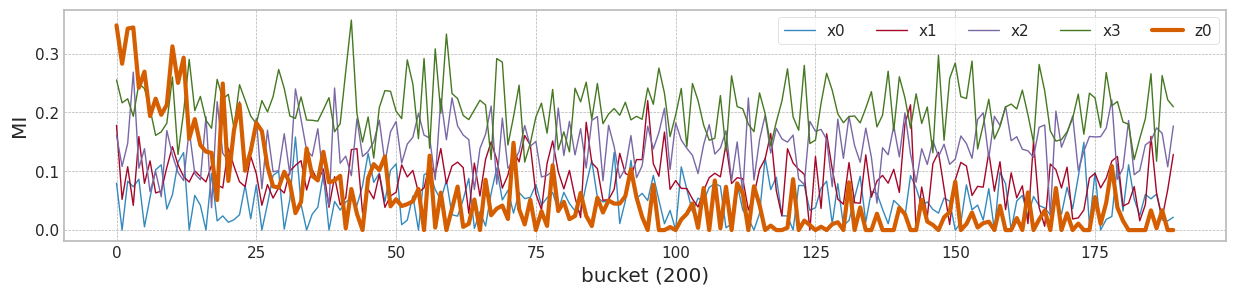

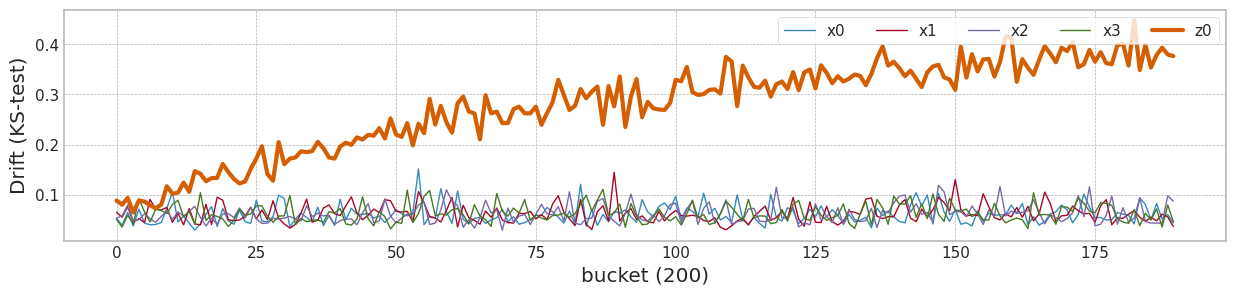

In [127]:
from tqdm import tqdm

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    '''
    df_mis['x0'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x1'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x2'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x3'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['z0'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

### 학습 및 전체 예측

+ 2000개를 학습하고, 이후 38000개를 추정한다.

cuda:0


100%|██████████| 1000/1000 [00:29<00:00, 34.03it/s]


MSE: 0.26
RMSE: 0.51


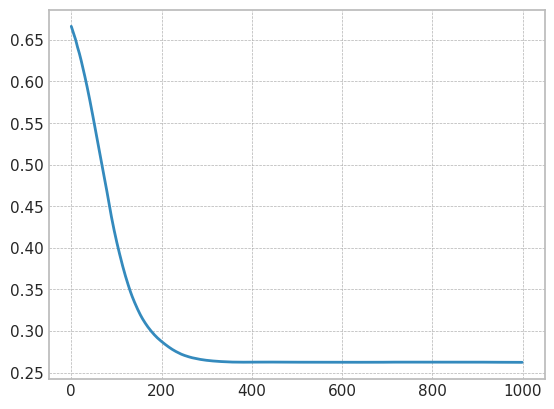

In [ ]:
import copy
import torch.optim as optim

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

100%|██████████| 189/189 [00:00<00:00, 479.91it/s]


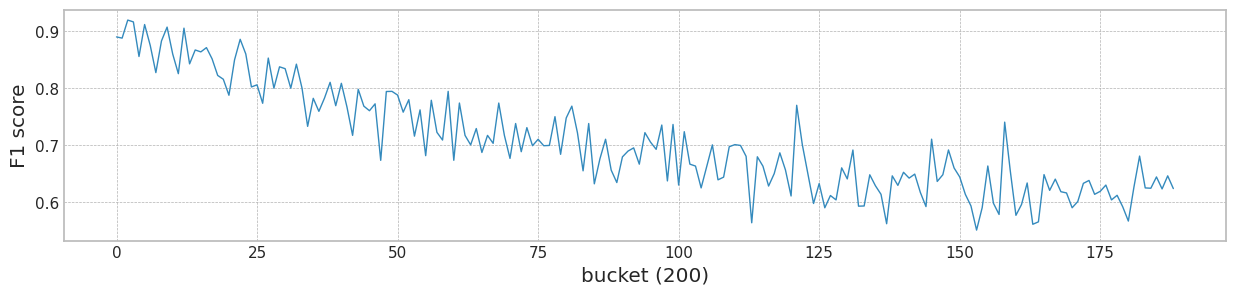

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853       0.0

In [ ]:

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

result_table3['lambda'].append('Case #1 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

### 내성 학습의 적용

In [ ]:

# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

lambda_f2 1.2
cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.663064]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.629238]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.596062]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.559978]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.521746]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.483910]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.442913]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.404920]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.372141]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.343308]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.318049]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.297169]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.280244

100%|██████████| 189/189 [00:03<00:00, 53.62it/s]


mean of drift:
x0    0.061049
x1    0.062651
x2    0.061975
x3    0.063260
z0    0.276490
dtype: float64
Mean F1 for all data: 0.7088965272551265
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 19.316162] [G loss: 0.511208]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 105.180084] [G loss: 0.266944]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 188.331757] [G loss: 0.227124]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 210.090500] [G loss: 0.224848]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 220.921432] [G loss: 0.223697]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 229.876511] [G loss: 0.222694]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 237.072784] [G loss: 0.221774]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 244.026840] [G loss: 0.220871]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 251.326172] [G loss: 0.220045]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 257.993988] [G loss: 0.219292]
[Lambda: 0

100%|██████████| 189/189 [00:03<00:00, 52.21it/s]


mean of drift:
x0    0.999994
x1    0.467075
x2    0.854297
x3    0.995676
z0    0.830808
dtype: float64
Mean F1 for all data: 0.721176812135385
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.020037] [G loss: 0.623222]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.078506] [G loss: 0.569837]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.167775] [G loss: 0.496585]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.265451] [G loss: 0.416552]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.298769] [G loss: 0.355171]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.284817] [G loss: 0.316309]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.253056] [G loss: 0.292837]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.220653] [G loss: 0.277176]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.190217] [G loss: 0.266409]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.167690] [G loss: 0.257279]
[Lambda: 0.100000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 51.99it/s]


mean of drift:
x0    0.551255
x1    0.256379
x2    0.524550
x3    0.315938
z0    0.565006
dtype: float64
Mean F1 for all data: 0.38773448433790614
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.007139] [G loss: 0.627994]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.018357] [G loss: 0.583075]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.039199] [G loss: 0.526471]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.066431] [G loss: 0.461640]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.086831] [G loss: 0.401224]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.093520] [G loss: 0.353786]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.091924] [G loss: 0.320146]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.084111] [G loss: 0.297693]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.075252] [G loss: 0.281987]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.066586] [G loss: 0.270301]
[Lambda: 0.200000] [Epoch 22

100%|██████████| 189/189 [00:03<00:00, 52.08it/s]


mean of drift:
x0    0.171287
x1    0.571105
x2    0.313474
x3    0.440703
z0    0.245938
dtype: float64
Mean F1 for all data: 0.5728063349608085
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.005376] [G loss: 0.629871]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.006886] [G loss: 0.588285]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.014519] [G loss: 0.538230]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.025471] [G loss: 0.480858]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.035334] [G loss: 0.424462]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.041426] [G loss: 0.376283]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.043034] [G loss: 0.339537]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.040916] [G loss: 0.312969]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.037128] [G loss: 0.293951]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.032860] [G loss: 0.279442]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 51.16it/s]


mean of drift:
x0    0.115285
x1    0.438019
x2    0.240750
x3    0.123175
z0    0.261429
dtype: float64
Mean F1 for all data: 0.7850010068760686
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.005101] [G loss: 0.630879]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.003148] [G loss: 0.591079]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.006397] [G loss: 0.544595]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.011234] [G loss: 0.491947]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.016194] [G loss: 0.438926]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.019932] [G loss: 0.391833]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.021470] [G loss: 0.354412]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.021262] [G loss: 0.325588]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.019570] [G loss: 0.304038]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.017511] [G loss: 0.287310]
[Lambda: 0.400000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 50.78it/s]


mean of drift:
x0    0.118119
x1    0.151725
x2    0.175441
x3    0.488292
z0    0.524888
dtype: float64
Mean F1 for all data: 0.7659473098764698
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.005159] [G loss: 0.631501]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.001599] [G loss: 0.592844]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.003039] [G loss: 0.548592]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.005177] [G loss: 0.499179]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.007710] [G loss: 0.448796]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.009757] [G loss: 0.403218]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.010920] [G loss: 0.365708]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.010945] [G loss: 0.336137]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.010325] [G loss: 0.312799]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.009238] [G loss: 0.294069]
[Lambda: 0.500000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 52.07it/s]


mean of drift:
x0    0.092269
x1    0.107687
x2    0.107266
x3    0.162663
z0    0.245082
dtype: float64
Mean F1 for all data: 0.8244244113177561
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.005296] [G loss: 0.631926]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.000920] [G loss: 0.594047]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.001478] [G loss: 0.551396]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.002448] [G loss: 0.504040]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.003603] [G loss: 0.455949]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.004680] [G loss: 0.411699]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.005354] [G loss: 0.374579]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.005465] [G loss: 0.344564]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.005190] [G loss: 0.320457]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.004633] [G loss: 0.300408]
[Lambda: 0.600000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 52.05it/s]


mean of drift:
x0    0.067493
x1    0.084621
x2    0.099165
x3    0.095288
z0    0.184744
dtype: float64
Mean F1 for all data: 0.8060833514922492
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.005442] [G loss: 0.632233]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.000630] [G loss: 0.594915]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.000662] [G loss: 0.553504]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.001035] [G loss: 0.507932]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.001551] [G loss: 0.461480]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.002032] [G loss: 0.418524]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.002417] [G loss: 0.381711]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.002499] [G loss: 0.351338]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.002388] [G loss: 0.326485]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.002161] [G loss: 0.305532]
[Lambda: 0.700000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 51.30it/s]


mean of drift:
x0    0.062892
x1    0.074521
x2    0.079133
x3    0.074018
z0    0.240808
dtype: float64
Mean F1 for all data: 0.730102436404008
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.005581] [G loss: 0.632467]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.000497] [G loss: 0.595641]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000316] [G loss: 0.555041]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000401] [G loss: 0.510713]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.000560] [G loss: 0.465739]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.000725] [G loss: 0.424046]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.000863] [G loss: 0.387982]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.000912] [G loss: 0.357326]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.000899] [G loss: 0.331731]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.000830] [G loss: 0.309941]
[Lambda: 0.800000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 51.42it/s]


mean of drift:
x0    0.061931
x1    0.071449
x2    0.073474
x3    0.079997
z0    0.255838
dtype: float64
Mean F1 for all data: 0.7209201312161698
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.005705] [G loss: 0.632652]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.000453] [G loss: 0.596164]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000182] [G loss: 0.556232]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000127] [G loss: 0.512988]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000144] [G loss: 0.469201]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000171] [G loss: 0.428535]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000195] [G loss: 0.393073]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000204] [G loss: 0.362482]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000197] [G loss: 0.336422]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000184] [G loss: 0.314011]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 50.28it/s]


mean of drift:
x0    0.062281
x1    0.065967
x2    0.069280
x3    0.076690
z0    0.266705
dtype: float64
Mean F1 for all data: 0.714946437788246


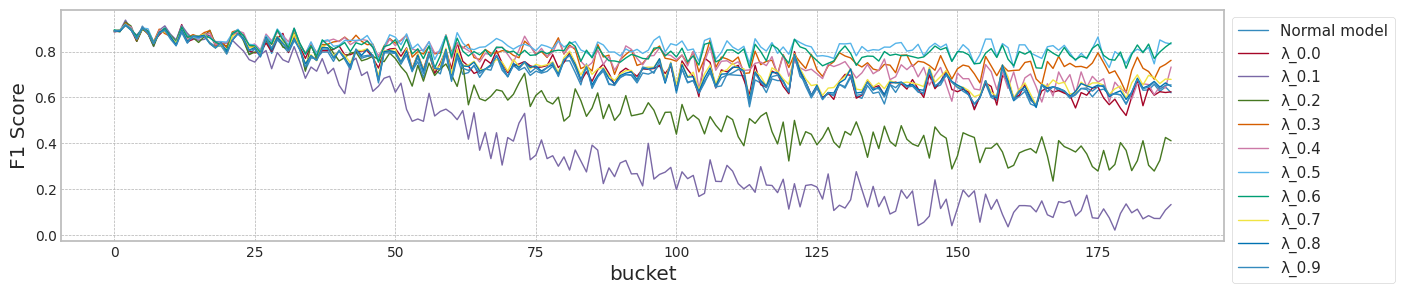

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #1, Normal model  0.881356  0.884793  0.708897  0.620370  0.259820
1                     0.0  0.898876  0.889908  0.721177  0.624390  0.265435
2                     0.1  0.870056  0.889908  0.387734  0.133333  0.229369
3                     0.2  0.858757  0.890909  0.572806  0.410959  0.228114
4                     0.3  0.865169  0.886878  0.785001  0.761905  0.250609
5                     0.4  0.870056  0.885845  0.765947  0.732673  0.266231
6                     0.5  0.875000  0.889908  0.824424  0.833333  0.261667
7                     0.6  0.881356  0.894977  0.806083  0.837945  0.259820
8                     0.7  0.875000  0.889908  0.730102  0.678733  0.261667
9                     0.8  0.875000  0.889908  0.720920  0.648402  0.261667
10                    0.9  0.875000  0.889908  0.714946  0.654545  0.261667
max_mean_lambda= 0.5


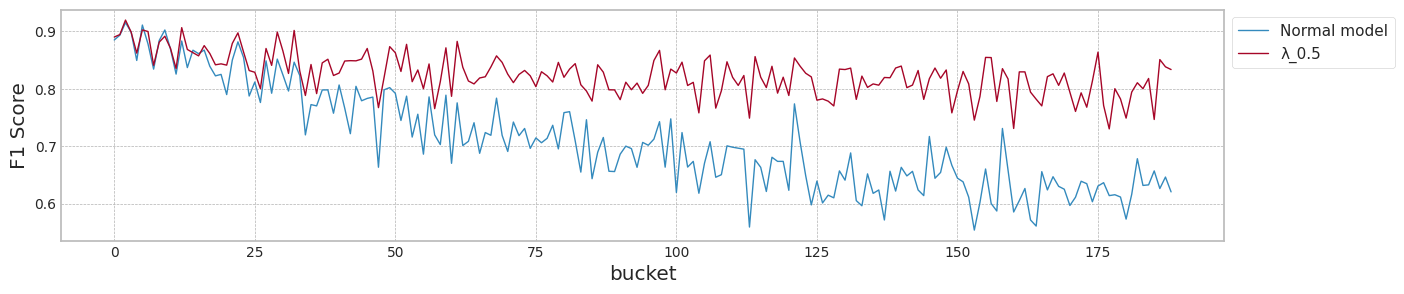

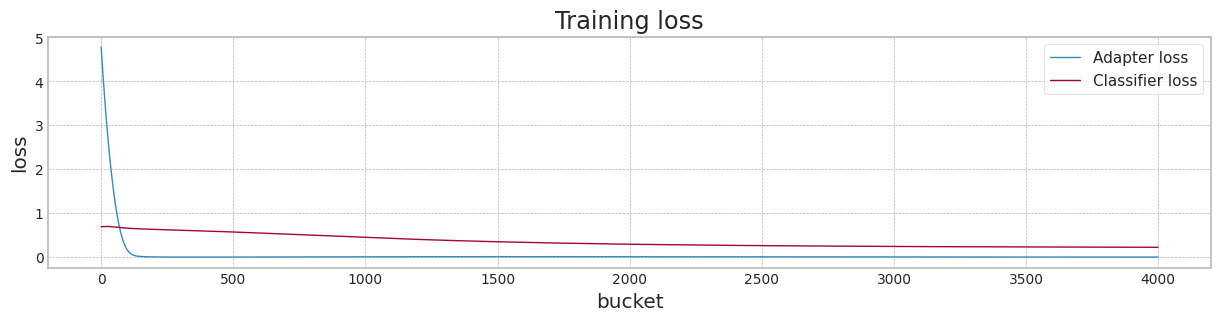

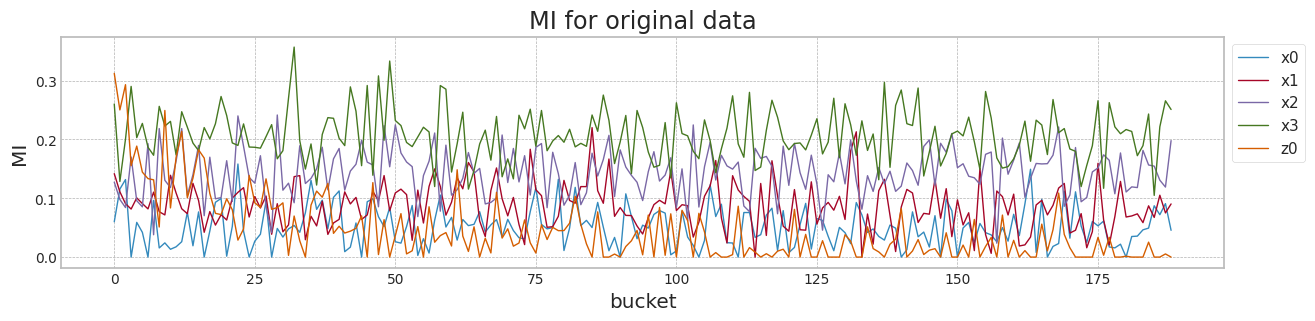

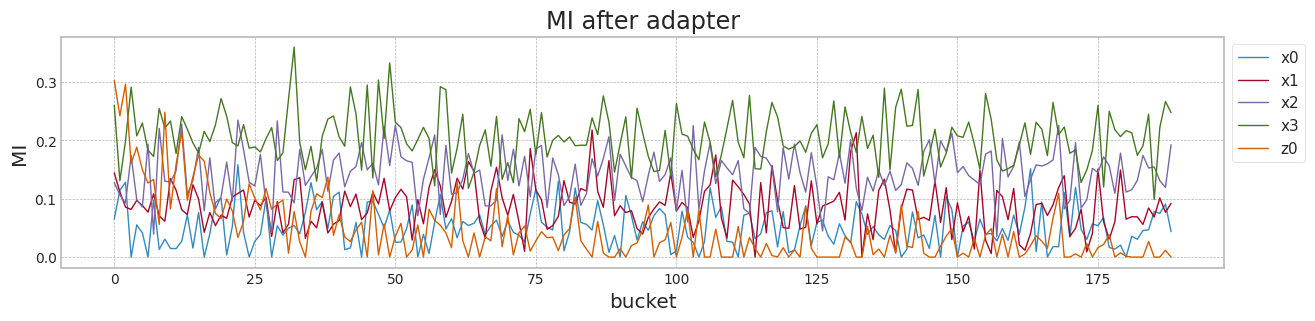

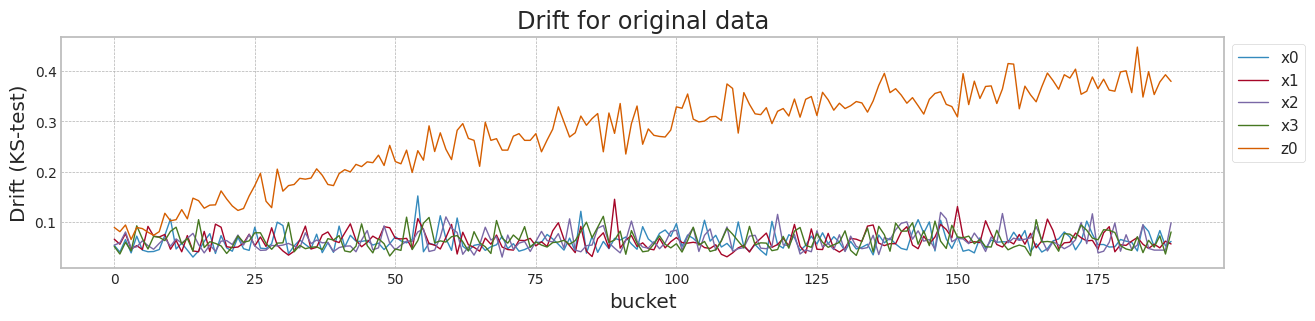

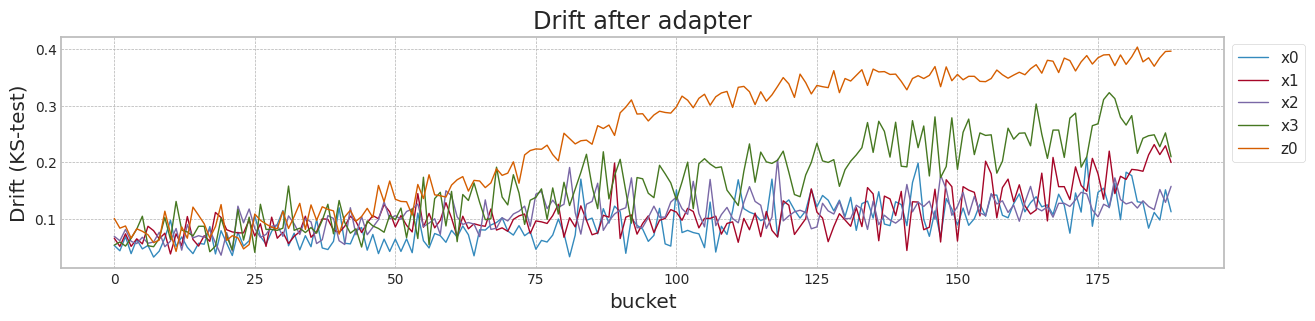

In [ ]:
avaible_range = 400
seed = 1
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
lambda_f_set2 = [1.2]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X[0:1800][['x0','x1','x2','x3','z0']],X[2000:][['x0','x1','x2','x3','z0','b']],y[2000:])
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()


## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

In [269]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [270]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [271]:
x1.shape

(40000, 5)

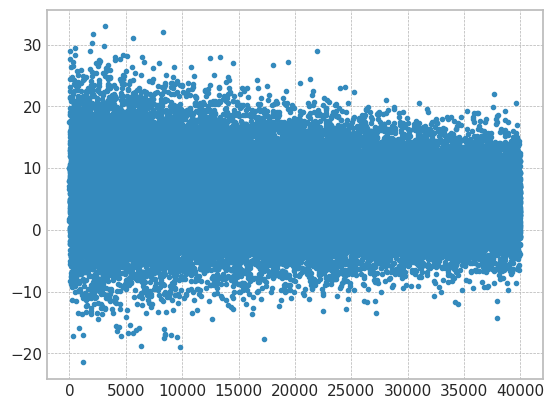

In [272]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

plt.plot(y1_array,'.')

In [273]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


In [274]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

x0    0.227465
z0    0.088169
x1    0.018550
x3    0.008429
x2    0.006772
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 66.80it/s]


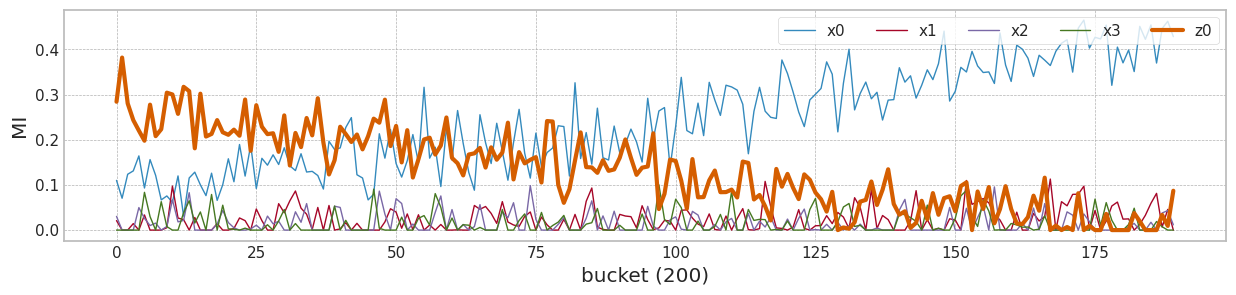

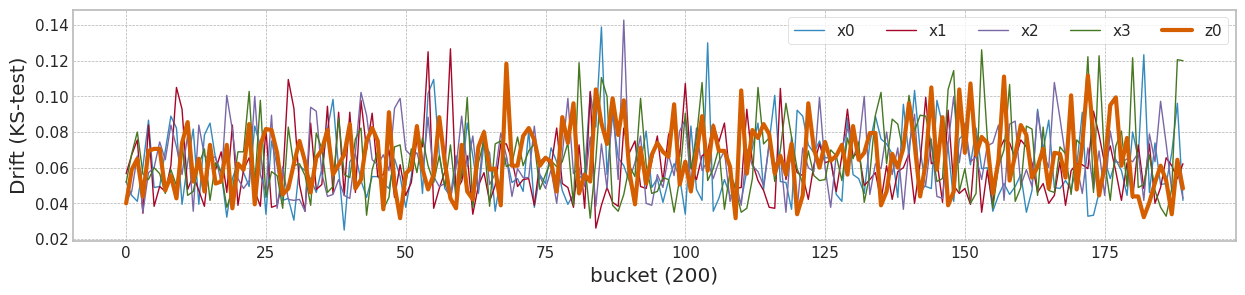

In [275]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X1[bk*bucket_size:bk*bucket_size+bucket_size], y1[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X1[0:1800].values,X1[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

### 학습 및 전체 예측

cuda:0


100%|██████████| 1000/1000 [00:25<00:00, 39.46it/s]


MSE: 0.04
RMSE: 0.19


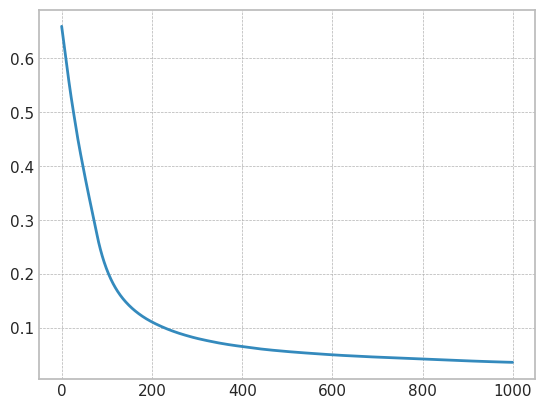

feature 5, test_f1 0.9868995633187774


In [276]:
import copy
import torch.optim as optim

seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y1[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y1[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

100%|██████████| 189/189 [00:00<00:00, 488.67it/s]


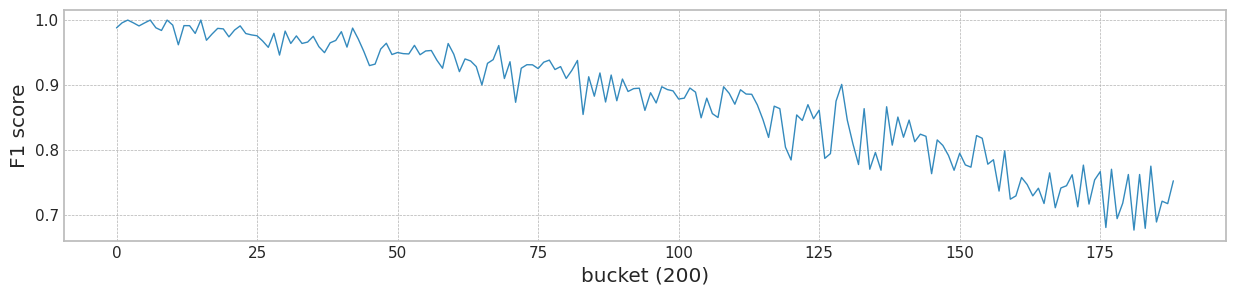

lambda  test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #2 Feature 5   0.9869  0.987952  0.877103  0.752137  0.087066

In [277]:
XT = X1[2000:][['x0','x1','x2','x3','z0']]
yT = y1[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

result_table3['lambda'].append('Case #2 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

In [278]:
X1['b'] = [int(b) for b in X1.index.values]
X1

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792 -1.925585      0
1      2.846794  0.461018  1.213784  1.282154  3.281450      1
2      2.232850  0.876278  2.307393  2.019052  0.187403      2
3     -0.198843  2.579531  0.078102  1.019118  2.385340      3
4      1.618080  1.683218  1.826908  0.697273  0.195648      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070  4.096949  39995
39996 -0.037401  1.055617  0.084065  1.252068  3.850920  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.498200  39997
39998  0.823467  1.489013 -0.191516 -0.238143  5.022454  39998
39999  2.024101  2.498025  0.198514  2.241146  0.816579  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.670989]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.601290]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.527616]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.460968]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.401566]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.338360]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.282020]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.238982]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.206156]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.180878]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.161100]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.145068]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.131681]
[Lambda: -0.

100%|██████████| 189/189 [00:03<00:00, 56.47it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.065844
dtype: float64
Mean F1 for all data: 0.8676675451930798
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 44.337929] [G loss: 0.479356]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 258.603058] [G loss: 0.167605]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 517.607544] [G loss: 0.078098]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 741.547424] [G loss: 0.051432]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 960.810425] [G loss: 0.037684]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 1181.940186] [G loss: 0.029118]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 1411.487183] [G loss: 0.022937]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 1654.074341] [G loss: 0.018343]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 1889.434204] [G loss: 0.015104]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 2127.275635] [G loss: 0.012432]
[Lamb

100%|██████████| 189/189 [00:03<00:00, 55.52it/s]


mean of drift:
x0    0.514368
x1    0.625579
x2    0.981046
x3    1.000000
z0    0.524045
dtype: float64
Mean F1 for all data: 0.9129560221808936
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.065951] [G loss: 0.575243]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.078144] [G loss: 0.493714]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.099995] [G loss: 0.420184]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.136796] [G loss: 0.340409]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.146494] [G loss: 0.270942]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.138476] [G loss: 0.221807]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.127138] [G loss: 0.185755]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.116526] [G loss: 0.158431]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.107120] [G loss: 0.137230]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.099970] [G loss: 0.120165]
[Lambda: 0.100000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 54.04it/s]


mean of drift:
x0    0.423574
x1    0.220714
x2    0.598610
x3    0.568613
z0    0.260894
dtype: float64
Mean F1 for all data: 0.7833643820519409
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.018489] [G loss: 0.584703]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.019629] [G loss: 0.504157]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.022988] [G loss: 0.436378]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.033968] [G loss: 0.364682]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.040136] [G loss: 0.293834]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.040487] [G loss: 0.240804]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.038645] [G loss: 0.201636]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.036420] [G loss: 0.172037]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.034431] [G loss: 0.149101]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.032889] [G loss: 0.130767]
[Lambda: 0.200000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 54.75it/s]


mean of drift:
x0    0.364312
x1    0.116805
x2    0.578122
x3    0.335165
z0    0.172002
dtype: float64
Mean F1 for all data: 0.8695814142813798
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.010342] [G loss: 0.588097]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.007837] [G loss: 0.508489]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.008714] [G loss: 0.442148]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.012524] [G loss: 0.375815]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.015766] [G loss: 0.306562]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.016355] [G loss: 0.251562]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.016089] [G loss: 0.210864]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.015498] [G loss: 0.180158]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.015158] [G loss: 0.156224]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.014811] [G loss: 0.137167]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 55.17it/s]


mean of drift:
x0    0.292119
x1    0.077166
x2    0.470509
x3    0.145500
z0    0.123460
dtype: float64
Mean F1 for all data: 0.9156953502345548
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.007799] [G loss: 0.589868]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.003998] [G loss: 0.510795]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.004074] [G loss: 0.445162]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.005486] [G loss: 0.382395]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.007194] [G loss: 0.315968]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.007550] [G loss: 0.259067]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.007546] [G loss: 0.217348]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.007504] [G loss: 0.185821]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.007392] [G loss: 0.161405]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.007369] [G loss: 0.141970]
[Lambda: 0.400000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 55.57it/s]


mean of drift:
x0    0.216514
x1    0.099597
x2    0.402066
x3    0.089935
z0    0.112384
dtype: float64
Mean F1 for all data: 0.924911304364104
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.006791] [G loss: 0.590945]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.002412] [G loss: 0.512229]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.002156] [G loss: 0.447056]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.002640] [G loss: 0.386431]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.003465] [G loss: 0.323261]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.003699] [G loss: 0.264581]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.003740] [G loss: 0.221905]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.003696] [G loss: 0.189941]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.003674] [G loss: 0.165207]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.003734] [G loss: 0.145577]
[Lambda: 0.500000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 53.78it/s]


mean of drift:
x0    0.134206
x1    0.095770
x2    0.252028
x3    0.076473
z0    0.095797
dtype: float64
Mean F1 for all data: 0.9114407924489931
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.006339] [G loss: 0.591663]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.001672] [G loss: 0.513202]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.001261] [G loss: 0.448361]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.001353] [G loss: 0.388887]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.001693] [G loss: 0.328799]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.001831] [G loss: 0.269610]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.001838] [G loss: 0.225904]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.001815] [G loss: 0.193371]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.001827] [G loss: 0.168297]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.001864] [G loss: 0.148571]
[Lambda: 0.600000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 54.68it/s]


mean of drift:
x0    0.089286
x1    0.094071
x2    0.121755
x3    0.075844
z0    0.084168
dtype: float64
Mean F1 for all data: 0.900023537259777
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.006126] [G loss: 0.592189]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.001305] [G loss: 0.513911]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.000822] [G loss: 0.449310]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.000745] [G loss: 0.390311]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.000821] [G loss: 0.332271]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.000864] [G loss: 0.273652]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.000854] [G loss: 0.228932]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.000837] [G loss: 0.195970]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.000845] [G loss: 0.170716]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.000878] [G loss: 0.150909]
[Lambda: 0.700000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 53.43it/s]


mean of drift:
x0    0.073918
x1    0.082684
x2    0.081690
x3    0.075773
z0    0.075270
dtype: float64
Mean F1 for all data: 0.89094844102321
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.006028] [G loss: 0.592582]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.001120] [G loss: 0.514450]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000607] [G loss: 0.450032]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000449] [G loss: 0.391394]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.000406] [G loss: 0.334911]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.000388] [G loss: 0.277870]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.000364] [G loss: 0.231717]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.000349] [G loss: 0.198266]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.000350] [G loss: 0.172791]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.000358] [G loss: 0.152966]
[Lambda: 0.800000] [Epoch 2200/

100%|██████████| 189/189 [00:03<00:00, 54.13it/s]


mean of drift:
x0    0.068304
x1    0.071822
x2    0.070988
x3    0.073801
z0    0.068771
dtype: float64
Mean F1 for all data: 0.8855025678733823
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.005988] [G loss: 0.592887]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.001032] [G loss: 0.514873]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000507] [G loss: 0.450607]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000317] [G loss: 0.392248]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000227] [G loss: 0.337018]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000180] [G loss: 0.282182]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000150] [G loss: 0.234360]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000133] [G loss: 0.200385]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000124] [G loss: 0.174716]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000119] [G loss: 0.154858]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 55.26it/s]


mean of drift:
x0    0.064056
x1    0.064006
x2    0.067472
x3    0.073489
z0    0.065641
dtype: float64
Mean F1 for all data: 0.878191295430785


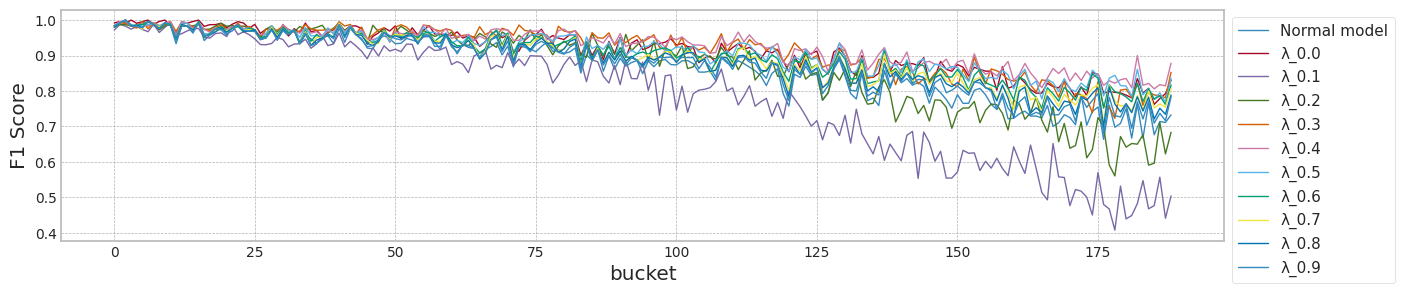

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #1, Normal model  0.969697  0.984000  0.867668  0.732759  0.280002
1                     0.0  0.986667  0.991935  0.912956  0.830357  0.296459
2                     0.1  0.969957  0.972112  0.783364  0.503597  0.307413
3                     0.2  0.973913  0.980080  0.869581  0.683230  0.292253
4                     0.3  0.973913  0.984000  0.915695  0.852632  0.292253
5                     0.4  0.978166  0.984000  0.924911  0.878505  0.304856
6                     0.5  0.973913  0.984000  0.911441  0.835443  0.293090
7                     0.6  0.969697  0.980080  0.900024  0.816667  0.280002
8                     0.7  0.969697  0.980080  0.890948  0.806584  0.280002
9                     0.8  0.969697  0.980080  0.885503  0.788382  0.280002
10                    0.9  0.969697  0.984000  0.878191  0.783333  0.280002
max_mean_lambda= 0.4


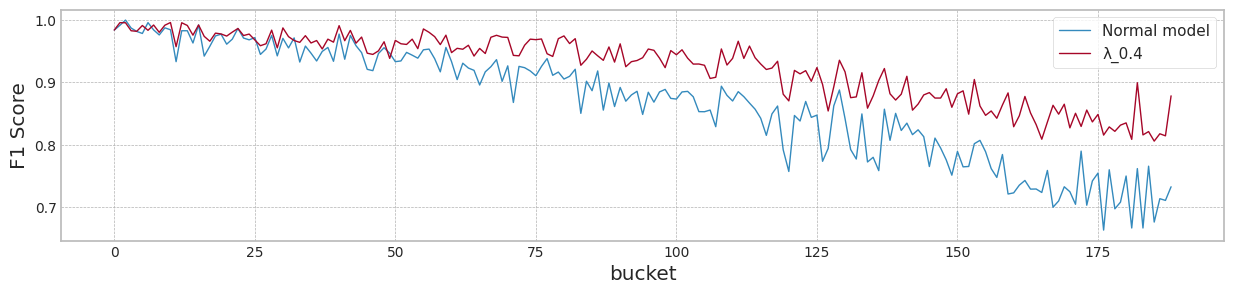

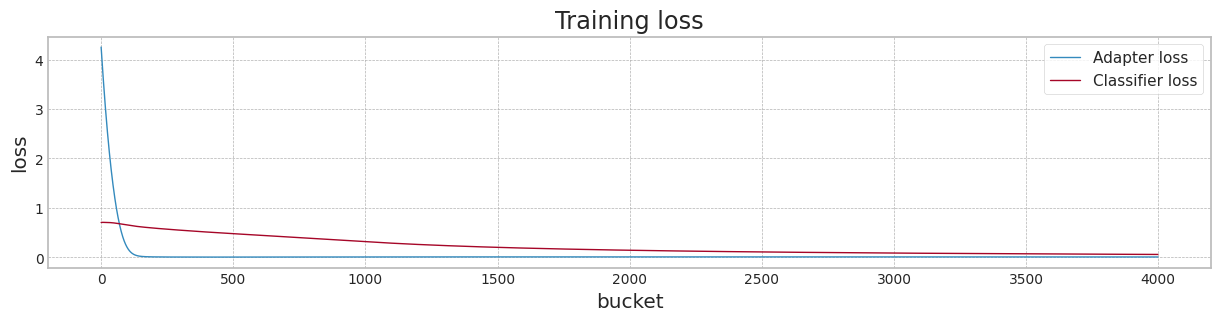

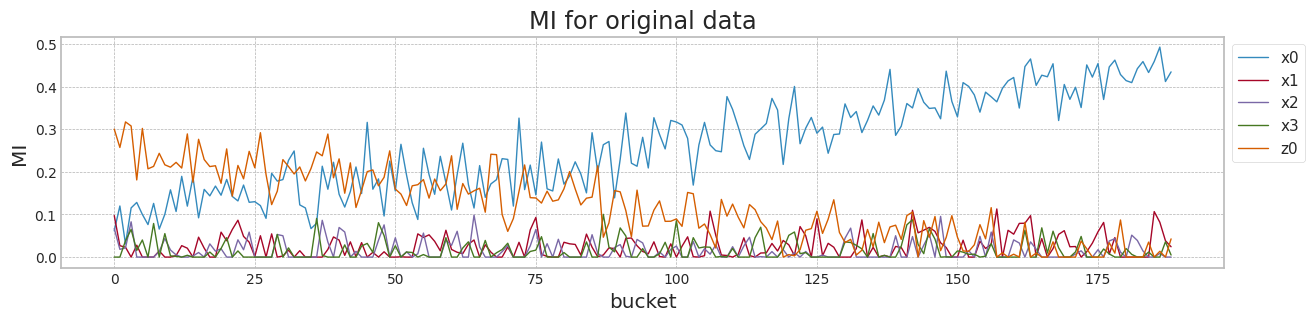

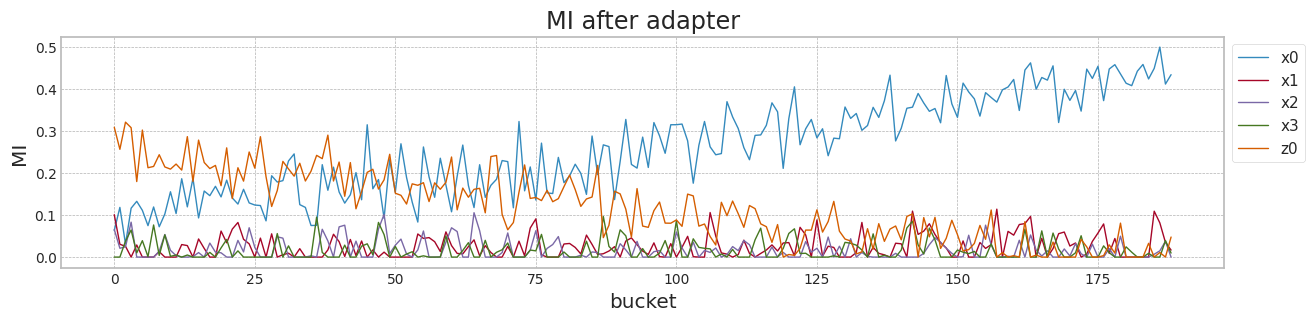

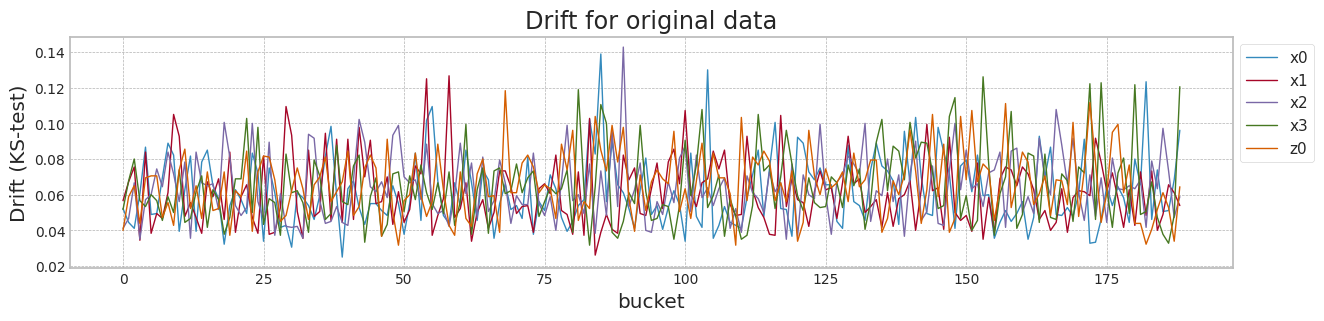

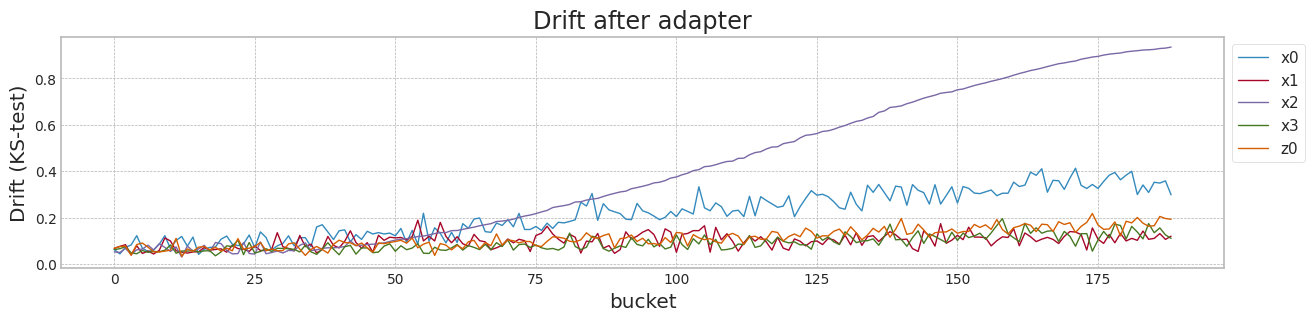

In [279]:
seed_everything()

train_result = []

avaible_range = 40000

train_tensors = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [-0.1, 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091]
lambda_f_set2 = [1.2]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf  = test_all_data(last_generator,last_adapter,X1[0:1800][['x0','x1','x2','x3','z0']],X1[2000:][['x0','x1','x2','x3','z0','b']],y1[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### data 생성

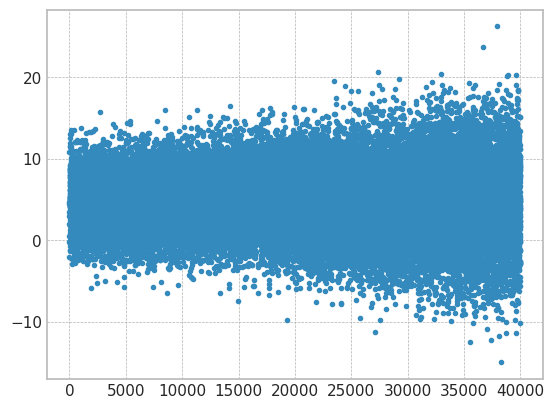

In [280]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0, 3*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

plt.plot(y2_array,'.')

In [281]:
m = 5 #np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

5


18973

In [282]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

z0    0.143465
x0    0.139701
x1    0.050595
x2    0.017249
x3    0.000037
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 200/200 [00:03<00:00, 64.50it/s]


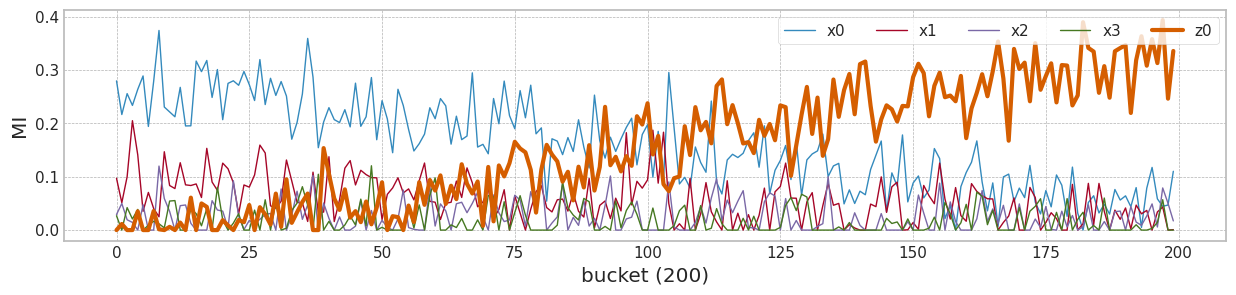

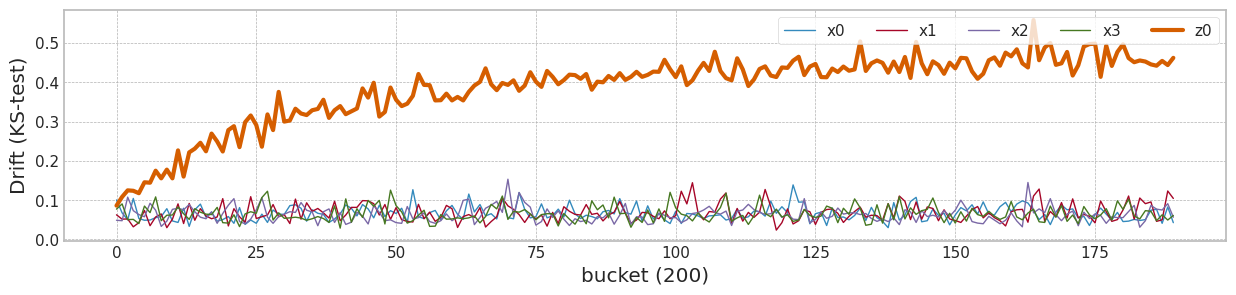

In [283]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((X2.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2[bk*bucket_size:bk*bucket_size+bucket_size], y2[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X2[0:1800].values,X2[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    '''
    df_mis['x0'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x1'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x2'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x3'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['z0'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

### 학습 및 전체 예측

#### concept drift tolerant 학습

In [284]:
X2['b'] = [int(b) for b in X2.index.values]
X2

x0        x1        x2        x3         z0      b
0      0.374863 -1.631348  0.402315  2.034420   0.234180      0
1      0.915600  1.426389  0.828936  0.880705   0.590522      1
2     -2.204294  0.529797  0.275024  0.250469   0.296802      2
3      3.460406  2.383576  1.788045  0.707186   1.415130      3
4     -1.690153  1.036373  0.147557  1.113972   0.374363      4
...         ...       ...       ...       ...        ...    ...
39995 -0.403808  1.761956  0.330192  1.256819   4.232284  39995
39996  0.254364  2.391830  0.630682  0.345254  -4.065950  39996
39997  0.139385  1.201390 -1.015328  0.740202  11.706228  39997
39998  0.347711  1.943623  2.942906  1.648642 -10.003689  39998
39999  0.547857  0.793047  0.676551  0.716256  -6.142285  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.678268]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.638633]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.592907]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.538921]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.480219]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.423210]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.372952]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.331069]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.296420]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.267782]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.243990]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.223458]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.205457]
[Lambda: -0.

100%|██████████| 189/189 [00:03<00:00, 58.08it/s]


mean of drift:
x0    0.066817
x1    0.067307
x2    0.063521
x3    0.065220
z0    0.385173
dtype: float64
Mean F1 for all data: 0.8494016761853732
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 39.494209] [G loss: 0.488699]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 191.394363] [G loss: 0.252860]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 524.439941] [G loss: 0.130579]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 948.898926] [G loss: 0.078925]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 1393.366211] [G loss: 0.055654]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 1872.298218] [G loss: 0.042257]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 2342.749756] [G loss: 0.033609]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 2819.607178] [G loss: 0.027466]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 3300.576904] [G loss: 0.022405]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 3803.261475] [G loss: 0.018285]
[Lam

100%|██████████| 189/189 [00:03<00:00, 57.45it/s]


mean of drift:
x0    0.565867
x1    0.759353
x2    0.988721
x3    1.000000
z0    0.855294
dtype: float64
Mean F1 for all data: 0.9445365018548598
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.034259] [G loss: 0.624003]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.094542] [G loss: 0.558819]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.191707] [G loss: 0.473497]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.257611] [G loss: 0.387948]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.280936] [G loss: 0.321857]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.281844] [G loss: 0.272022]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.276723] [G loss: 0.233028]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.269280] [G loss: 0.201927]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.260584] [G loss: 0.176698]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.250343] [G loss: 0.155939]
[Lambda: 0.100000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 56.84it/s]


mean of drift:
x0    0.414474
x1    0.157205
x2    0.708904
x3    0.151382
z0    0.427478
dtype: float64
Mean F1 for all data: 0.5351992431660273
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.009229] [G loss: 0.630204]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.021929] [G loss: 0.574680]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.044680] [G loss: 0.508073]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.069986] [G loss: 0.428046]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.082260] [G loss: 0.361143]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.087461] [G loss: 0.307535]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.088163] [G loss: 0.265578]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.087450] [G loss: 0.232564]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.086769] [G loss: 0.206014]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.086200] [G loss: 0.184233]
[Lambda: 0.200000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 54.82it/s]


mean of drift:
x0    0.364409
x1    0.108771
x2    0.265185
x3    0.416049
z0    0.491734
dtype: float64
Mean F1 for all data: 0.5642992859456024
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.005141] [G loss: 0.632361]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.008097] [G loss: 0.580890]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.016537] [G loss: 0.521538]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.027429] [G loss: 0.446912]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.033714] [G loss: 0.381187]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.036822] [G loss: 0.327183]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.038019] [G loss: 0.283863]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.038172] [G loss: 0.249946]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.037955] [G loss: 0.223140]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.037819] [G loss: 0.201354]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 57.72it/s]


mean of drift:
x0    0.367252
x1    0.104688
x2    0.376437
x3    0.101972
z0    0.398151
dtype: float64
Mean F1 for all data: 0.5153769633767252
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.003985] [G loss: 0.633450]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.003662] [G loss: 0.584213]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.007131] [G loss: 0.528961]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.012336] [G loss: 0.458229]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.015643] [G loss: 0.393812]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.017384] [G loss: 0.339913]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.018267] [G loss: 0.296077]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.018499] [G loss: 0.261694]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.018461] [G loss: 0.234539]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.018307] [G loss: 0.212476]
[Lambda: 0.400000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 57.45it/s]


mean of drift:
x0    0.295764
x1    0.080391
x2    0.359162
x3    0.080091
z0    0.394994
dtype: float64
Mean F1 for all data: 0.5635775113687816
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.003577] [G loss: 0.634112]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.001814] [G loss: 0.586331]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.003314] [G loss: 0.533478]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.005822] [G loss: 0.465711]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.007556] [G loss: 0.402519]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.008510] [G loss: 0.348918]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.009019] [G loss: 0.305038]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.009166] [G loss: 0.270418]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.009091] [G loss: 0.243032]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.008927] [G loss: 0.220676]
[Lambda: 0.500000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 53.74it/s]


mean of drift:
x0    0.218677
x1    0.114947
x2    0.382190
x3    0.072210
z0    0.395579
dtype: float64
Mean F1 for all data: 0.618629645137041
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.003424] [G loss: 0.634543]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.000986] [G loss: 0.587762]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.001581] [G loss: 0.536520]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.002725] [G loss: 0.470983]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.003568] [G loss: 0.408914]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.004079] [G loss: 0.355693]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.004318] [G loss: 0.311877]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.004398] [G loss: 0.277140]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.004374] [G loss: 0.249500]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.004269] [G loss: 0.226807]
[Lambda: 0.600000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 57.21it/s]


mean of drift:
x0    0.178519
x1    0.121429
x2    0.227005
x3    0.073251
z0    0.393063
dtype: float64
Mean F1 for all data: 0.7427243732197626
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.003376] [G loss: 0.634863]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.000593] [G loss: 0.588807]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.000734] [G loss: 0.538798]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.001190] [G loss: 0.475027]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.001572] [G loss: 0.413864]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.001803] [G loss: 0.361028]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.001914] [G loss: 0.317243]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.001962] [G loss: 0.282393]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.001959] [G loss: 0.254565]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.001917] [G loss: 0.231589]
[Lambda: 0.700000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 56.61it/s]


mean of drift:
x0    0.141958
x1    0.093827
x2    0.144215
x3    0.071614
z0    0.391379
dtype: float64
Mean F1 for all data: 0.7965917189785734
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.003374] [G loss: 0.635105]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.000411] [G loss: 0.589605]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000338] [G loss: 0.540503]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000458] [G loss: 0.478120]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.000580] [G loss: 0.417819]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.000665] [G loss: 0.365338]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.000704] [G loss: 0.321665]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.000719] [G loss: 0.286795]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.000713] [G loss: 0.258834]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.000701] [G loss: 0.235653]
[Lambda: 0.800000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 54.98it/s]


mean of drift:
x0    0.099136
x1    0.077313
x2    0.083172
x3    0.071990
z0    0.387078
dtype: float64
Mean F1 for all data: 0.8411869495567947
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 2.813154] [G loss: 0.688778]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.003392] [G loss: 0.635299]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.000336] [G loss: 0.590237]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000171] [G loss: 0.541861]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000149] [G loss: 0.480617]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000156] [G loss: 0.421046]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000164] [G loss: 0.368948]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000168] [G loss: 0.325387]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000167] [G loss: 0.290506]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000163] [G loss: 0.262424]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000160] [G loss: 0.239098]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 55.78it/s]


mean of drift:
x0    0.075018
x1    0.066293
x2    0.065476
x3    0.070729
z0    0.386138
dtype: float64
Mean F1 for all data: 0.856044638331482


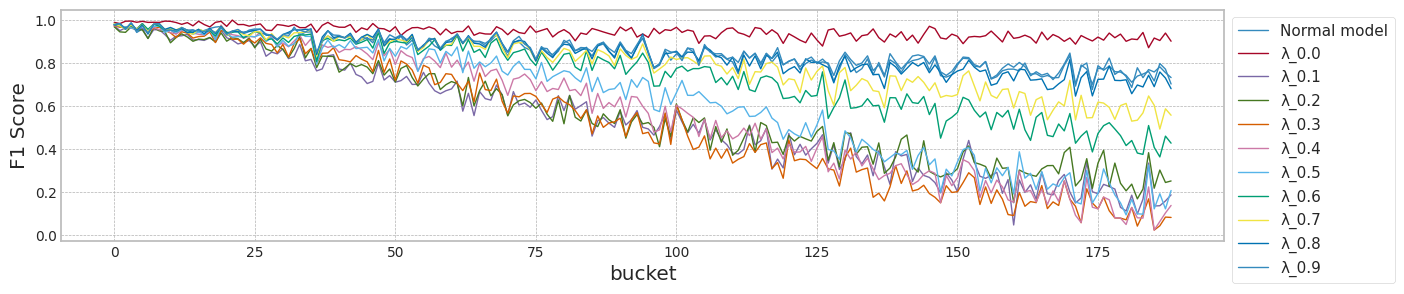

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #3, Normal model  0.979798  0.978723  0.849402  0.701987  0.004388
1                     0.0  0.990000  0.989247  0.944537  0.901408  0.004697
2                     0.1  0.980000  0.973545  0.535199  0.185185  0.008598
3                     0.2  0.965174  0.968421  0.564299  0.250000  0.032278
4                     0.3  0.980000  0.973545  0.515377  0.080000  0.000000
5                     0.4  0.975124  0.973545  0.563578  0.135922  0.001562
6                     0.5  0.980000  0.984127  0.618630  0.205607  0.002237
7                     0.6  0.980000  0.978947  0.742724  0.426230  0.002237
8                     0.7  0.980000  0.984127  0.796592  0.556391  0.002237
9                     0.8  0.984925  0.978723  0.841187  0.680272  0.004907
10                    0.9  0.979798  0.978723  0.856045  0.732026  0.004388
max_mean_lambda= 0.0


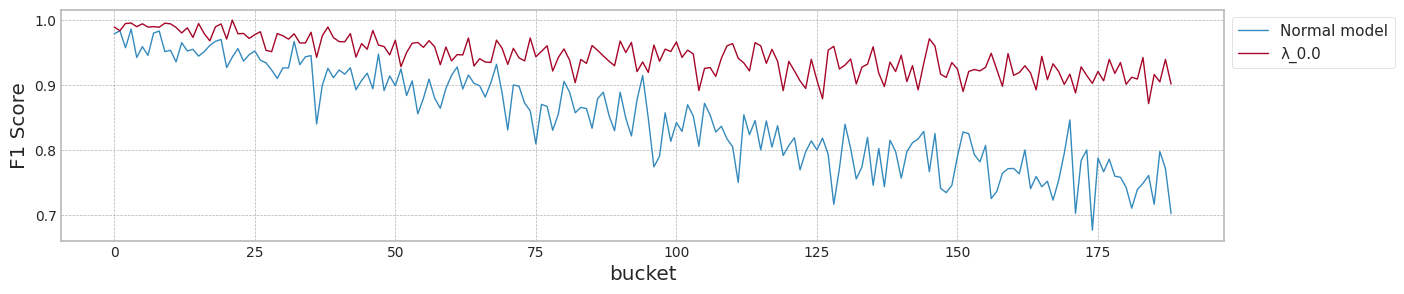

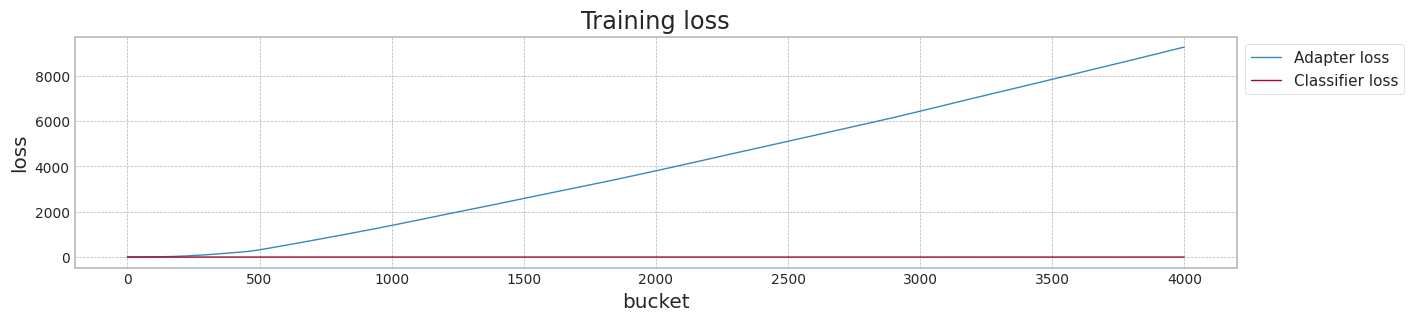

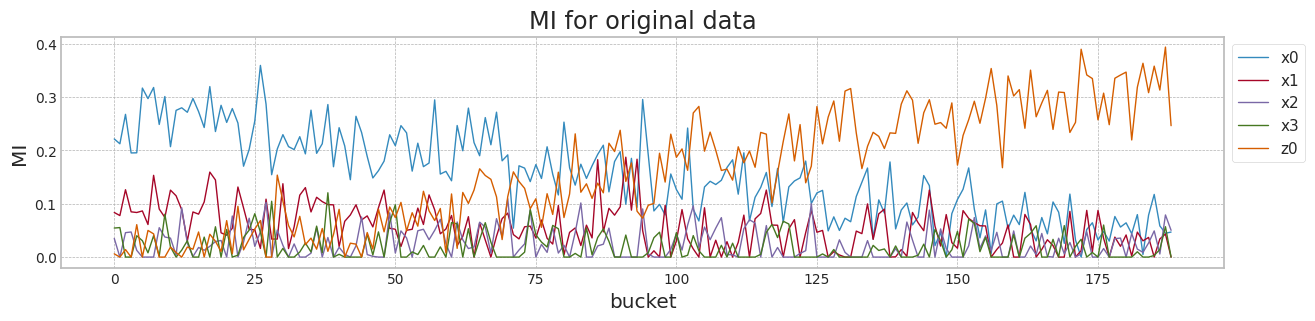

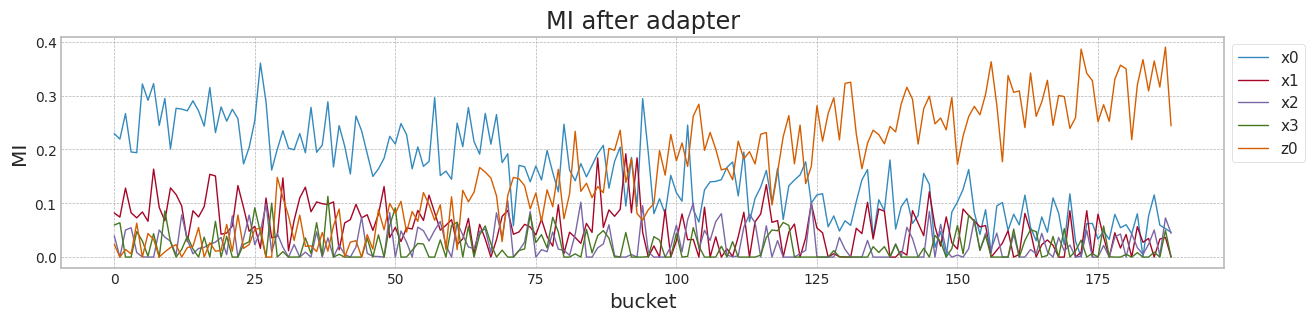

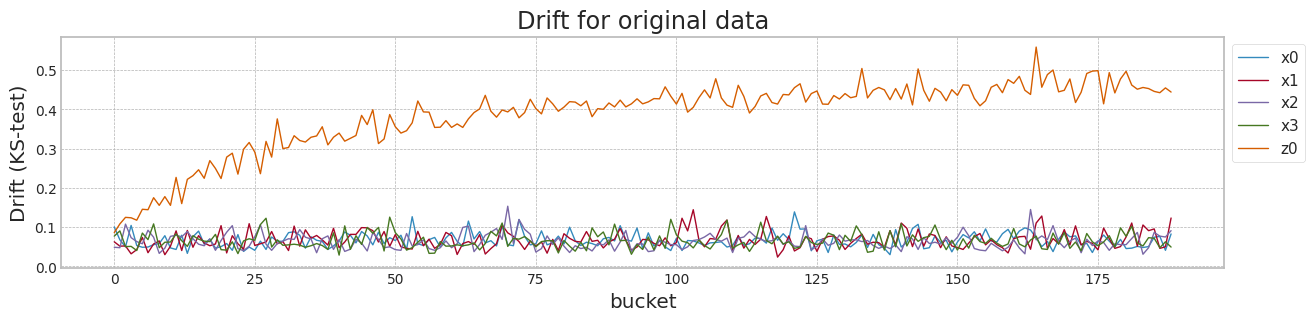

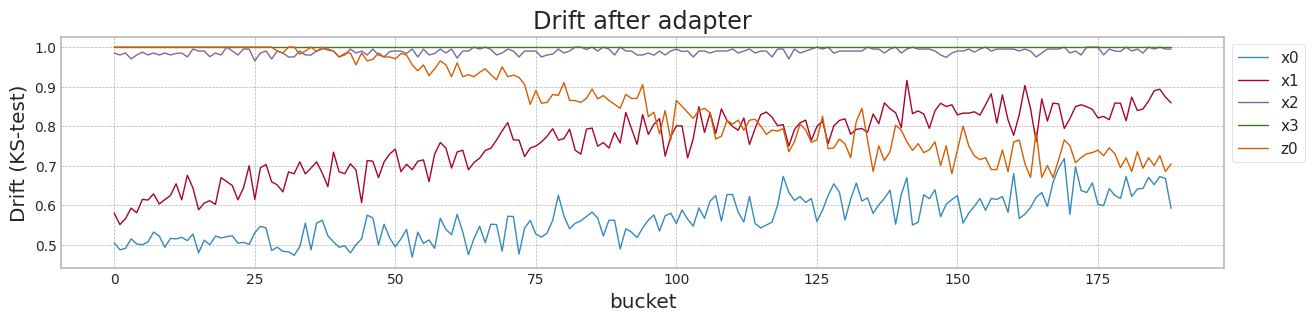

In [285]:

avaible_range = 40000

train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091]
lambda_f_set2 = [1.2]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X2[0:1800][['x0','x1','x2','x3','z0']],X2[2000:][['x0','x1','x2','x3','z0','b']],y2[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #3, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)


    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)


    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### data 생성 (Test)

In [293]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


In [294]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)
mi_scores = make_mi_scores(X3, y3, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
z0    0.091439
x1    0.079411
x0    0.050887
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 68.80it/s]


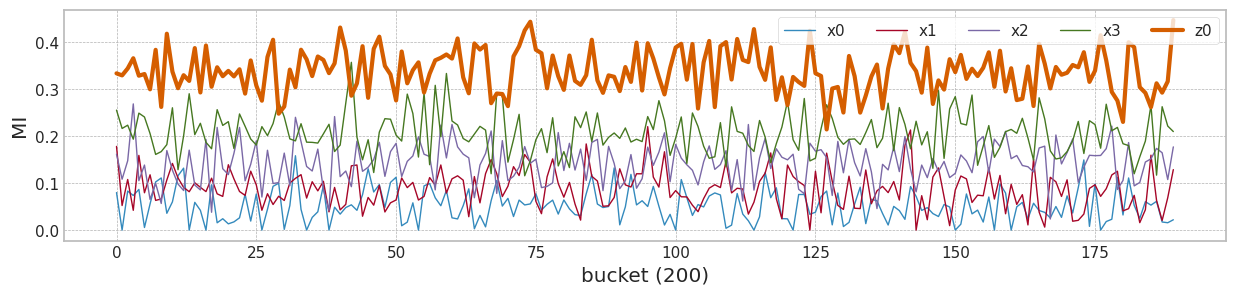

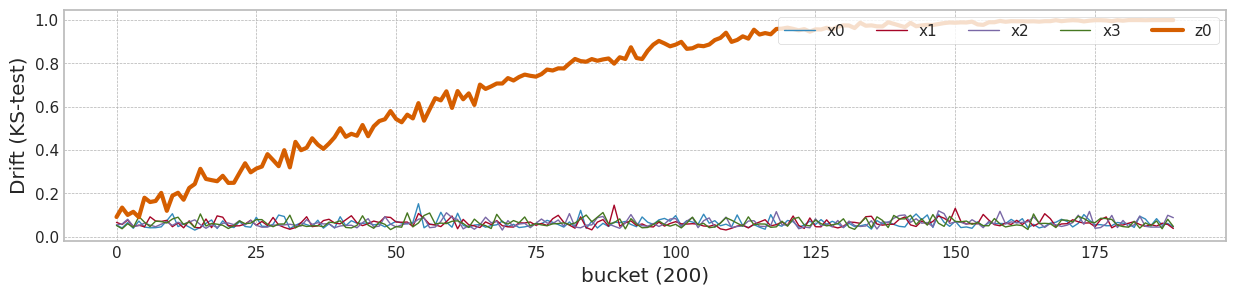

In [295]:
from tqdm import tqdm

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x3.shape[0]-2000)/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X3[bk*bucket_size:bk*bucket_size+bucket_size], y3[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X3[0:1800].values,X3[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

### 내성학습의 적용

In [296]:
X3['b'] = [int(b) for b in X3.index.values]
X3

x0        x1        x2        x3        z0      b
0      2.231833  0.663053  2.160447  1.180836  0.798517      0
1      1.326272  2.285045  2.362769  2.638806  1.293756      1
2      1.845348  3.743190  3.310210  1.772473  0.194608      2
3      2.974414 -0.229197  1.024580  1.387895  0.225398      3
4      2.854022  3.102544  1.610779  1.774781  1.385995      4
...         ...       ...       ...       ...       ...    ...
39995  0.085122 -0.571732  1.527233  1.867146  3.302407  39995
39996  1.069521 -0.221247  1.324087  1.798258  3.377813  39996
39997  0.429295  2.593988  2.329410  1.859496  4.929090  39997
39998  1.611266 -0.588687 -0.591898  2.126287  4.083001  39998
39999  3.872531  0.931353  3.595759  1.948642  4.916381  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.663298]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.630879]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.597093]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.552410]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.504487]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.456226]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.402422]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.353820]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.314069]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.282942]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.258917]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.240379]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.226279]
[Lambda: -0.

100%|██████████| 189/189 [00:03<00:00, 60.36it/s]


mean of drift:
x0    0.061049
x1    0.062651
x2    0.061975
x3    0.063260
z0    0.734850
dtype: float64
Mean F1 for all data: 0.7346962684009695
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 19.551746] [G loss: 0.496079]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 99.224113] [G loss: 0.229052]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 185.661713] [G loss: 0.180922]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 217.587524] [G loss: 0.175239]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 228.159424] [G loss: 0.173978]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 232.823746] [G loss: 0.173215]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 235.786636] [G loss: 0.172449]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 239.202774] [G loss: 0.171746]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 245.662277] [G loss: 0.170960]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 250.723190] [G loss: 0.170144]
[Lambda: 0.

100%|██████████| 189/189 [00:03<00:00, 58.04it/s]


mean of drift:
x0    0.999932
x1    0.999947
x2    0.757281
x3    0.984662
z0    0.885511
dtype: float64
Mean F1 for all data: 0.7484792889889847
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.034613] [G loss: 0.617995]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.091961] [G loss: 0.564331]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.163841] [G loss: 0.493374]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.255476] [G loss: 0.407360]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.275009] [G loss: 0.311746]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.243300] [G loss: 0.260085]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.206464] [G loss: 0.234053]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.178180] [G loss: 0.217557]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.155618] [G loss: 0.206135]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.135874] [G loss: 0.197695]
[Lambda: 0.100000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 58.01it/s]


mean of drift:
x0    0.244450
x1    0.454474
x2    0.826082
x3    0.498151
z0    0.328524
dtype: float64
Mean F1 for all data: 0.24615202924896973
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.010062] [G loss: 0.624382]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.020897] [G loss: 0.579478]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.040692] [G loss: 0.520334]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.068077] [G loss: 0.448248]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.095620] [G loss: 0.353959]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.088061] [G loss: 0.286785]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.076386] [G loss: 0.253318]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.064453] [G loss: 0.233258]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.055125] [G loss: 0.219272]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.047032] [G loss: 0.209171]
[Lambda: 0.200000] [Epoch 22

100%|██████████| 189/189 [00:03<00:00, 58.95it/s]


mean of drift:
x0    0.218833
x1    0.161820
x2    0.690150
x3    0.243907
z0    0.286402
dtype: float64
Mean F1 for all data: 0.4900797062290905
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.006039] [G loss: 0.626756]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.007843] [G loss: 0.585358]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.015268] [G loss: 0.531879]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.027048] [G loss: 0.467847]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.039391] [G loss: 0.394555]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.045046] [G loss: 0.331291]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.042731] [G loss: 0.288928]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.037439] [G loss: 0.260752]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.032234] [G loss: 0.241134]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.027492] [G loss: 0.226870]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 56.59it/s]


mean of drift:
x0    0.155694
x1    0.091917
x2    0.624653
x3    0.380215
z0    0.143225
dtype: float64
Mean F1 for all data: 0.5771763075190778
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.004946] [G loss: 0.627970]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.003492] [G loss: 0.588816]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.006743] [G loss: 0.538534]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.012141] [G loss: 0.479724]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.018490] [G loss: 0.413773]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.022584] [G loss: 0.348909]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.022524] [G loss: 0.302777]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.020448] [G loss: 0.270910]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.017662] [G loss: 0.248746]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.015075] [G loss: 0.232853]
[Lambda: 0.400000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 57.21it/s]


mean of drift:
x0    0.109988
x1    0.089956
x2    0.576614
x3    0.274891
z0    0.294101
dtype: float64
Mean F1 for all data: 0.7394471941109302
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.004600] [G loss: 0.628709]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.001753] [G loss: 0.590561]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.003120] [G loss: 0.542382]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.005737] [G loss: 0.486899]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.009232] [G loss: 0.425407]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.011928] [G loss: 0.359637]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.012438] [G loss: 0.311306]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.011454] [G loss: 0.277230]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.009873] [G loss: 0.253538]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.008299] [G loss: 0.236707]
[Lambda: 0.500000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 58.88it/s]


mean of drift:
x0    0.088545
x1    0.083051
x2    0.460679
x3    0.278892
z0    0.611376
dtype: float64
Mean F1 for all data: 0.8899698357960891
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.004502] [G loss: 0.629205]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.001036] [G loss: 0.591759]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.001544] [G loss: 0.545140]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.002727] [G loss: 0.492237]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.004351] [G loss: 0.435441]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.005890] [G loss: 0.370992]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.006409] [G loss: 0.321359]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.006080] [G loss: 0.285260]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.005264] [G loss: 0.259585]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.004425] [G loss: 0.241265]
[Lambda: 0.600000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 56.99it/s]


mean of drift:
x0    0.075603
x1    0.077522
x2    0.289059
x3    0.215068
z0    0.665626
dtype: float64
Mean F1 for all data: 0.8007333609064288
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.004501] [G loss: 0.629560]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.000713] [G loss: 0.592614]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.000779] [G loss: 0.547152]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.001249] [G loss: 0.496290]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.001897] [G loss: 0.442541]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.002681] [G loss: 0.380278]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.003018] [G loss: 0.330048]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.002914] [G loss: 0.292532]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.002563] [G loss: 0.265159]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.002153] [G loss: 0.245406]
[Lambda: 0.700000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 57.76it/s]


mean of drift:
x0    0.066190
x1    0.070461
x2    0.145714
x3    0.171276
z0    0.676822
dtype: float64
Mean F1 for all data: 0.7681525930413944
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.004537] [G loss: 0.629829]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.000598] [G loss: 0.593307]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000366] [G loss: 0.548671]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000465] [G loss: 0.499539]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.000691] [G loss: 0.448045]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.000969] [G loss: 0.388370]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.001145] [G loss: 0.338036]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.001139] [G loss: 0.299268]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.001029] [G loss: 0.270428]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.000869] [G loss: 0.249355]
[Lambda: 0.800000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 56.83it/s]


mean of drift:
x0    0.061393
x1    0.067704
x2    0.071590
x3    0.112372
z0    0.688239
dtype: float64
Mean F1 for all data: 0.7504244192068175
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.004587] [G loss: 0.630039]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.000525] [G loss: 0.593841]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000227] [G loss: 0.549836]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000157] [G loss: 0.502003]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000181] [G loss: 0.452343]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000228] [G loss: 0.395136]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000265] [G loss: 0.345222]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000269] [G loss: 0.305695]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000244] [G loss: 0.275724]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000208] [G loss: 0.253379]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 56.84it/s]


mean of drift:
x0    0.061399
x1    0.067072
x2    0.062287
x3    0.084297
z0    0.706820
dtype: float64
Mean F1 for all data: 0.7450711780086117


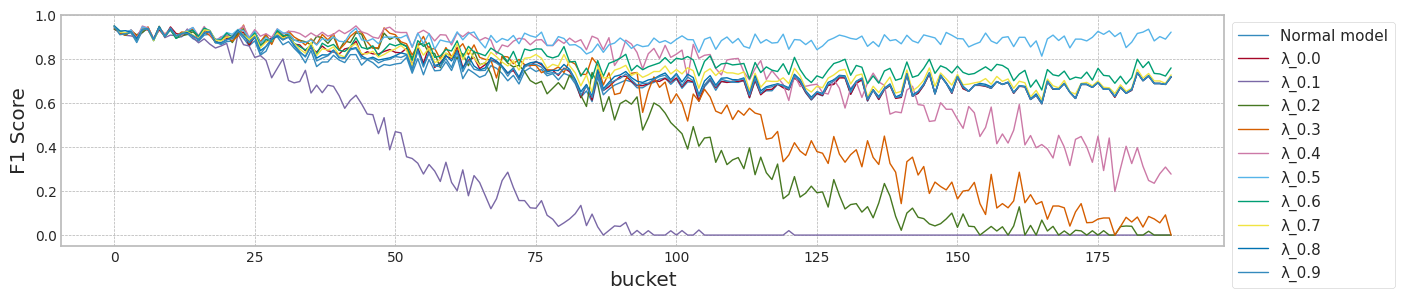

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #4, Normal model  0.906077  0.945455  0.734696  0.717949  0.433155
1                     0.0  0.906077  0.935185  0.748479  0.717949  0.415900
2                     0.1  0.921348  0.940092  0.246152  0.000000  0.431681
3                     0.2  0.916201  0.935780  0.490080  0.000000  0.416446
4                     0.3  0.911111  0.945455  0.577176  0.000000  0.437913
5                     0.4  0.911111  0.949772  0.739447  0.276923  0.437913
6                     0.5  0.906077  0.945455  0.889970  0.921739  0.449883
7                     0.6  0.911111  0.949772  0.800733  0.759322  0.437913
8                     0.7  0.911111  0.949772  0.768153  0.727273  0.437913
9                     0.8  0.906077  0.949772  0.750424  0.717949  0.449883
10                    0.9  0.907104  0.949772  0.745071  0.720257  0.453450
max_mean_lambda= 0.5


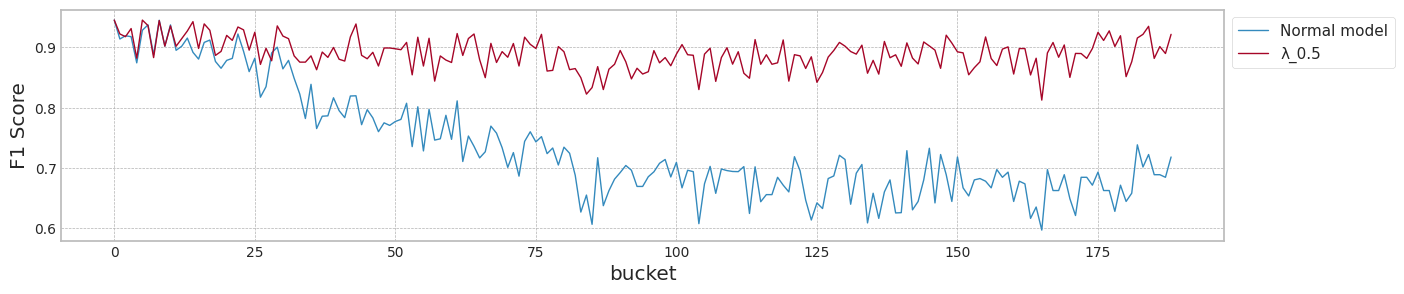

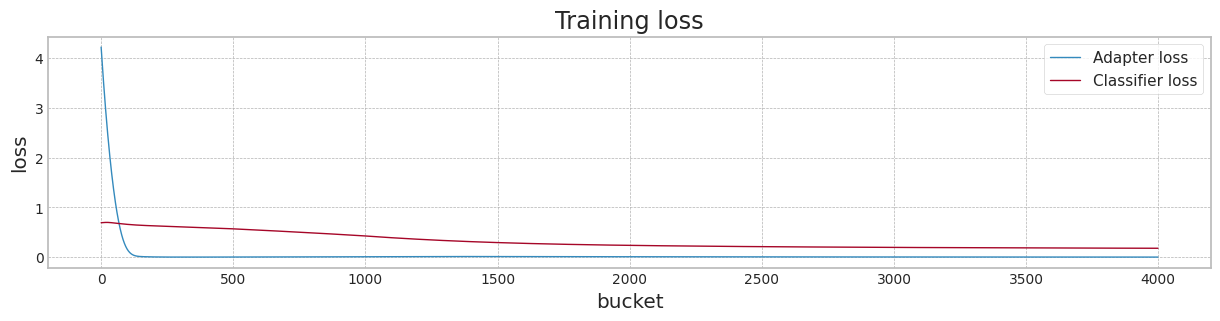

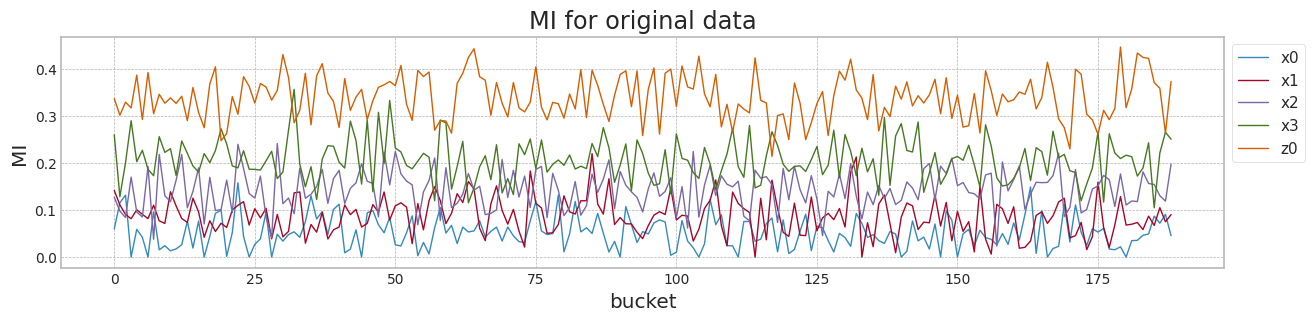

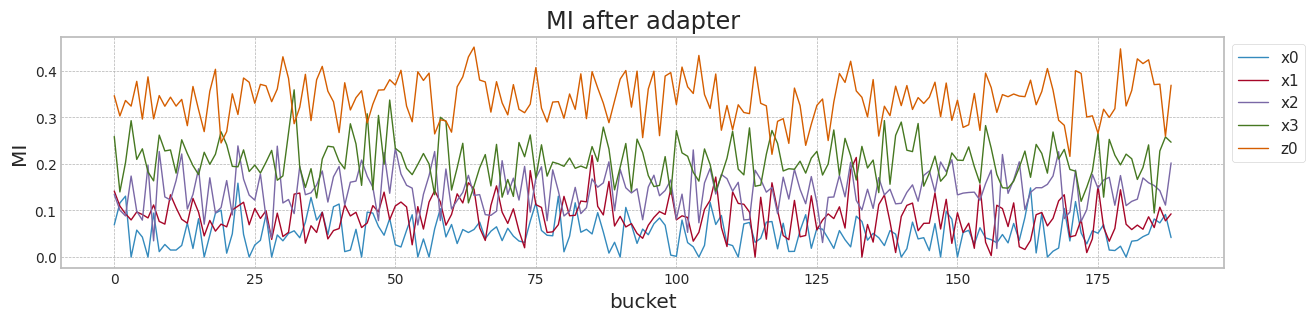

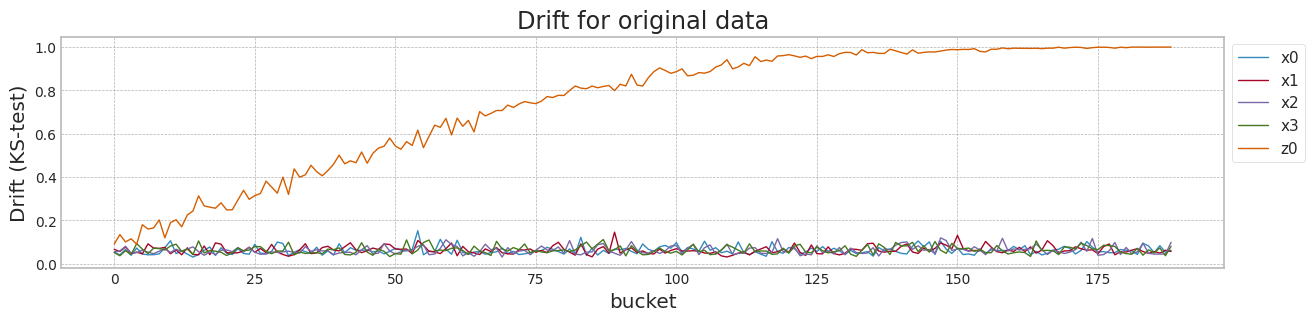

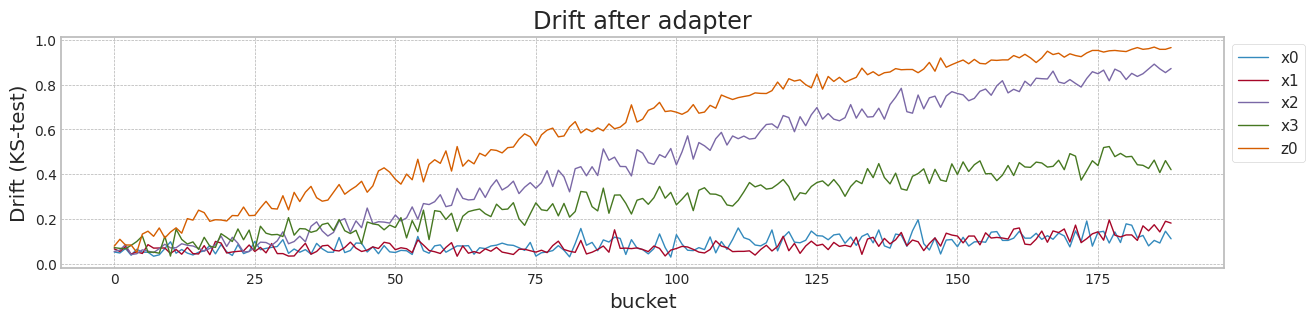

In [297]:
seed_everything()

train_result = []

avaible_range = 40000

train_tensors = Namespace(XS_train = torch.tensor(X3[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y3[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X3[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X3[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y3[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X3[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X3[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y3[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X3[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X3[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y3[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X3[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [-0.1, 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091]
lambda_f_set2 = [1.2]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf  = test_all_data(last_generator,last_adapter,X3[0:1800][['x0','x1','x2','x3','z0']],X3[2000:][['x0','x1','x2','x3','z0','b']],y3[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #4, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

# Case #5 (Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

In [300]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x[ii,3] = x[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


In [302]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

z0    0.125965
x2    0.113917
x0    0.076938
x1    0.025020
x3    0.007549
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:03<00:00, 58.62it/s]


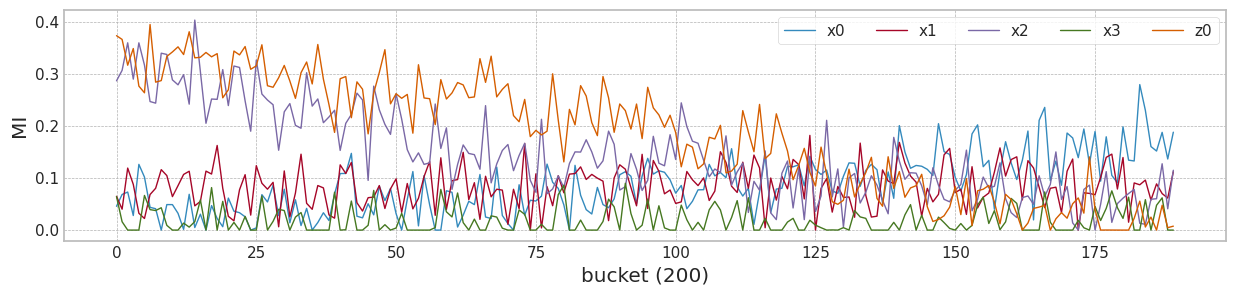

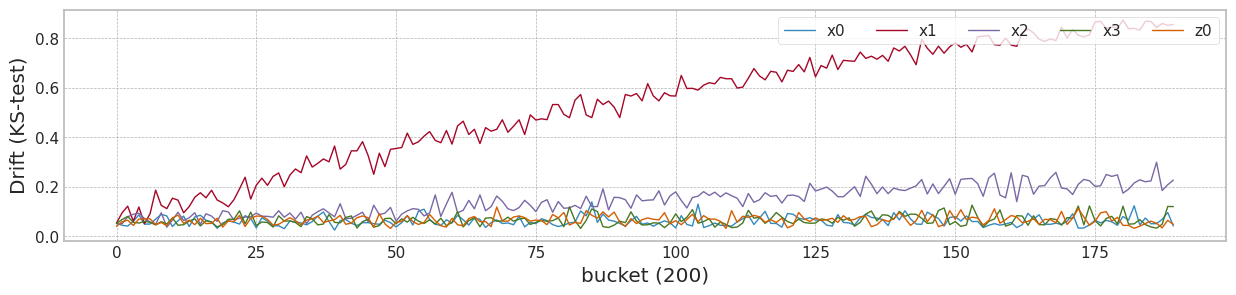

In [310]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)
    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X4[bk*bucket_size:bk*bucket_size+bucket_size], y4[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X4[0:1800].values,X4[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3','z0']].values,linewidth=1,label=['x0','x1','x2','x3','z0'])
    #plt.plot(df_mis[['x2','x3','z0']].values,linewidth=3,label=['x2','x3','z0'])
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3','z0']].values,linewidth=1,label=['x0','x1','x2','x3','z0'])
    #plt.plot(df_drf[['x2','x3','z0']].values,linewidth=3,label=['x2','x3','z0'])
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

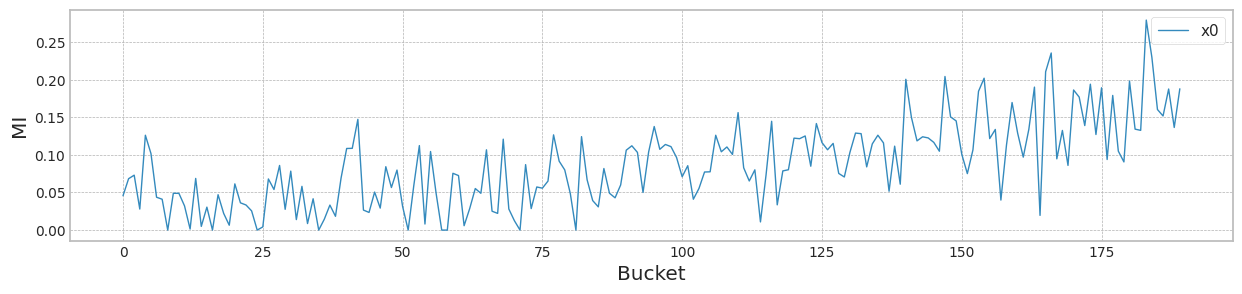

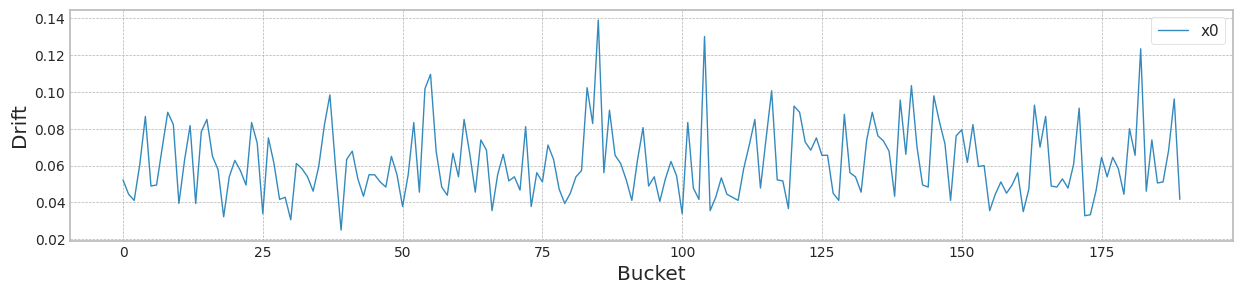

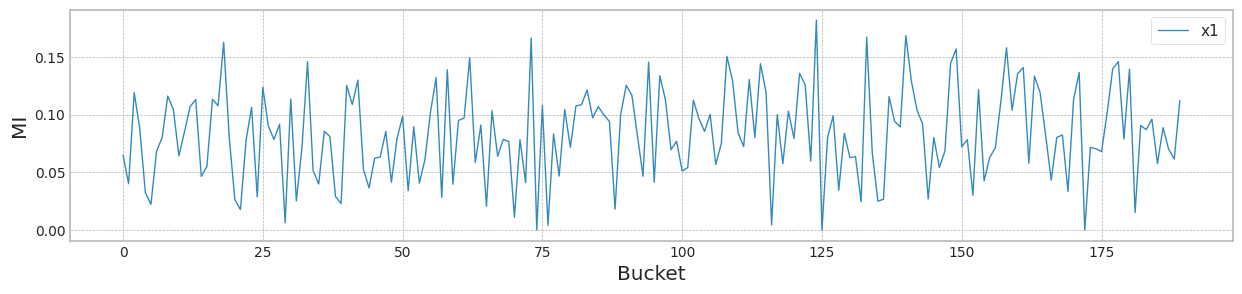

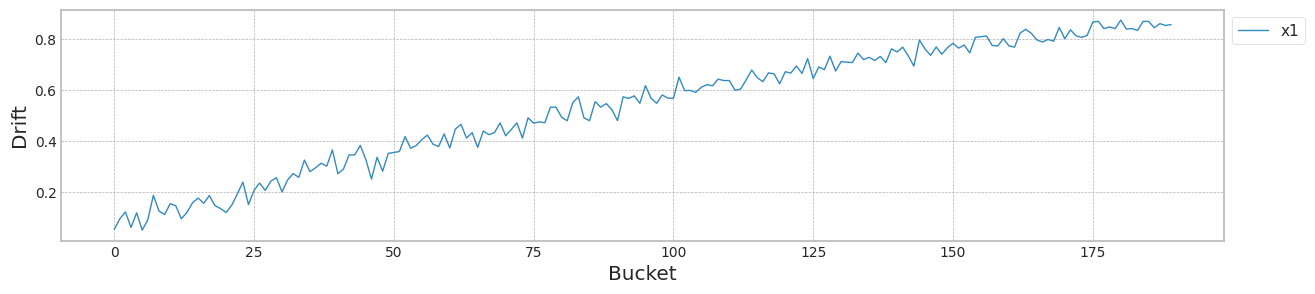

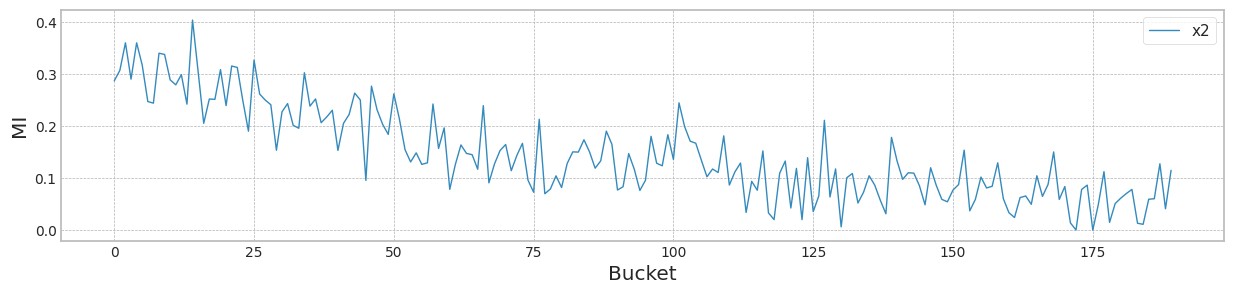

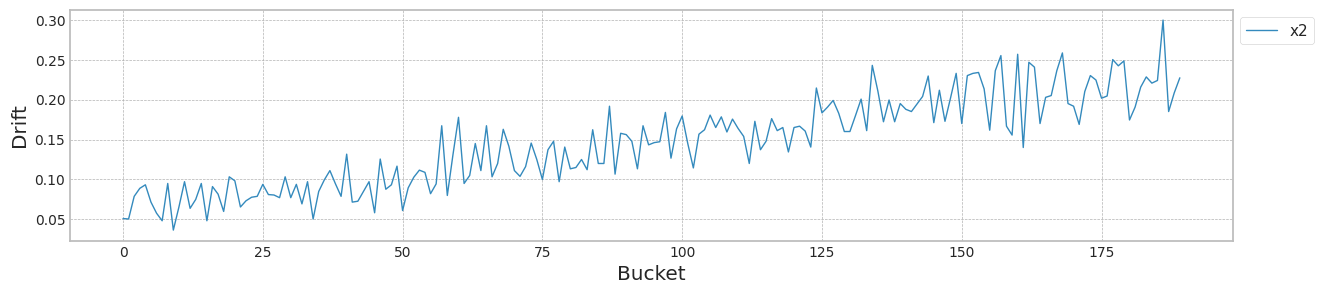

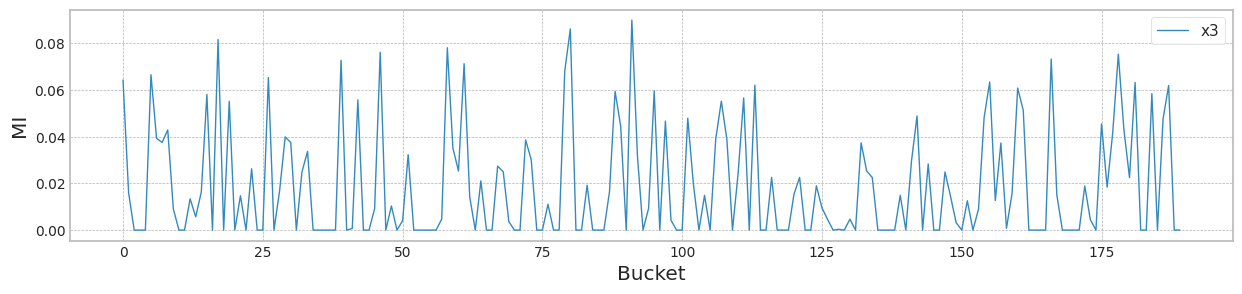

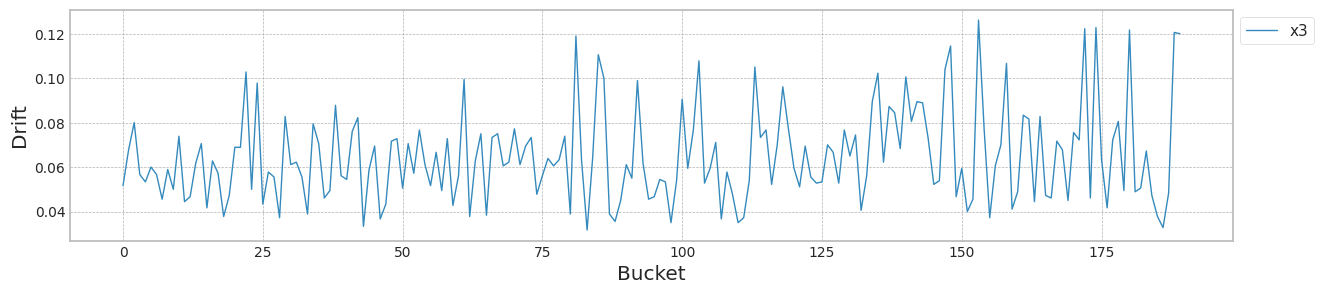

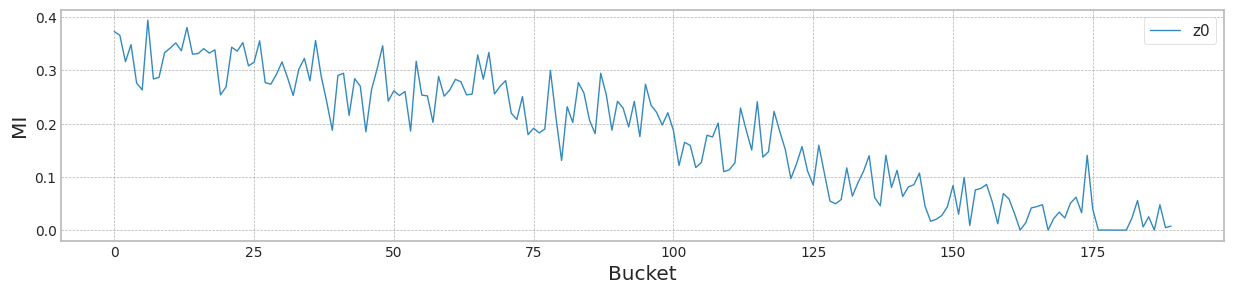

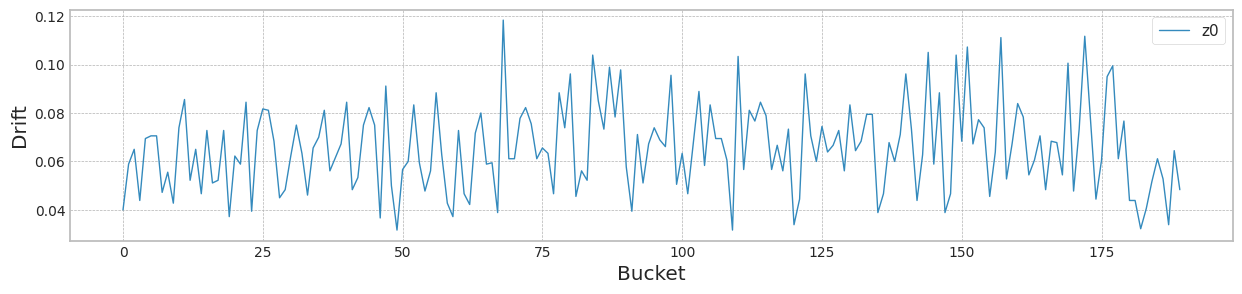

In [306]:
for cn in columns:
    df_mis[cn].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    df_drf[cn].plot(figsize=main_figsize,linewidth=1,ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

<table>
<tr>
<td>구분</td><td>x0</td><td>x1</td><td>x2</td><td>x3</td><td>z0</td>
</tr>
<tr>
<td>MI 증가</td><td>O</td><td>-</td><td>-</td><td>-</td><td>-</td>
</tr>
<tr>
<td>MI 감소</td><td>-</td><td>-</td><td>O</td><td>-</td><td>O</td>
</tr>
<tr>
<td>MI 고정</td><td>-</td><td>O</td><td>-</td><td>O</td><td>-</td>
</tr>

<tr>
<td>Drift 증가</td><td>-</td><td>O</td><td>O</td><td>-</td><td>-</td>
</tr>
<tr>
<td>Drift 감소</td><td>-</td><td>-</td><td>-</td><td>-</td><td>-</td>
</tr>
<tr>
<td>Drift 고정</td><td>O</td><td>-</td><td>-</td><td>O</td><td>O</td>
</tr>
</table>

## 내성학습의 적용!

In [307]:
X4['b'] = [int(b) for b in X4.index.values]
X4

x0        x1        x2        x3        z0      b
0      1.877314 -0.369296  0.569114  1.124792 -1.925585      0
1      2.846794  1.110108  0.988323  1.282154  3.281450      1
2      2.232850 -0.272503  1.924583  2.019052  0.187403      2
3     -0.198843  0.884187  2.853315  1.019118  2.385340      3
4      1.618080  1.456985  0.557992  0.697273  0.195648      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  2.597803  0.151293  1.410070  4.096949  39995
39996 -0.037401  6.590665  0.184651  1.252068  3.850920  39996
39997  2.262545  4.696481  1.347429  1.256208  0.498200  39997
39998  0.823467  5.432000  0.182464 -0.238143  5.022454  39998
39999  2.024101  4.804824 -0.661952  2.241146  0.816579  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.663298]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.630879]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.597093]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.552410]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.504487]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.456226]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.402422]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.353820]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.314069]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.282942]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.258917]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.240379]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.226279]
[Lambda: -0.

100%|██████████| 189/189 [00:03<00:00, 60.41it/s]


mean of drift:
x0    0.061681
x1    0.530761
x2    0.146041
x3    0.064427
z0    0.065844
dtype: float64
Mean F1 for all data: 0.7448086403890488
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 19.551746] [G loss: 0.496079]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 99.224113] [G loss: 0.229052]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 185.661713] [G loss: 0.180922]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 217.587524] [G loss: 0.175239]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 228.159424] [G loss: 0.173978]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 232.823746] [G loss: 0.173215]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 235.786636] [G loss: 0.172449]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 239.202774] [G loss: 0.171746]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 245.662277] [G loss: 0.170960]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 250.723190] [G loss: 0.170144]
[Lambda: 0.

100%|██████████| 189/189 [00:03<00:00, 56.37it/s]


mean of drift:
x0    0.999912
x1    1.000000
x2    0.774186
x3    0.969253
z0    0.473645
dtype: float64
Mean F1 for all data: 0.7071767195208227
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.047144] [G loss: 0.615950]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.125499] [G loss: 0.559723]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.219461] [G loss: 0.485766]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.334532] [G loss: 0.397346]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.350578] [G loss: 0.307566]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.300855] [G loss: 0.255990]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.252883] [G loss: 0.230267]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.217281] [G loss: 0.214422]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.189069] [G loss: 0.203318]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.166195] [G loss: 0.195049]
[Lambda: 0.100000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 57.31it/s]


mean of drift:
x0    0.544862
x1    0.500247
x2    0.735041
x3    0.340412
z0    0.344353
dtype: float64
Mean F1 for all data: 0.4207392854851677
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.012823] [G loss: 0.623272]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.029344] [G loss: 0.576804]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.056278] [G loss: 0.515295]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.095137] [G loss: 0.439258]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.114253] [G loss: 0.344556]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.109354] [G loss: 0.288402]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.095501] [G loss: 0.253071]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.081256] [G loss: 0.232297]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.070442] [G loss: 0.218013]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.060758] [G loss: 0.207705]
[Lambda: 0.200000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 58.28it/s]


mean of drift:
x0    0.166902
x1    0.657134
x2    0.679077
x3    0.405476
z0    0.430147
dtype: float64
Mean F1 for all data: 0.3606730306985712
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.006925] [G loss: 0.626079]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.011019] [G loss: 0.583568]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.021320] [G loss: 0.528464]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.037227] [G loss: 0.461882]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.053372] [G loss: 0.385450]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.058474] [G loss: 0.323757]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.054413] [G loss: 0.283235]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.047803] [G loss: 0.256215]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.041217] [G loss: 0.237436]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.035419] [G loss: 0.223621]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 52.18it/s]


mean of drift:
x0    0.197293
x1    0.557181
x2    0.656987
x3    0.542651
z0    0.393254
dtype: float64
Mean F1 for all data: 0.42775419388734615
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.005264] [G loss: 0.627533]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.004880] [G loss: 0.587496]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.009424] [G loss: 0.536003]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.017028] [G loss: 0.475153]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.025443] [G loss: 0.405847]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.030130] [G loss: 0.341735]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.029577] [G loss: 0.296999]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.026473] [G loss: 0.266620]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.022619] [G loss: 0.245720]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.019252] [G loss: 0.230510]
[Lambda: 0.400000] [Epoch 22

100%|██████████| 189/189 [00:03<00:00, 56.37it/s]


mean of drift:
x0    0.146675
x1    0.532190
x2    0.627913
x3    0.409588
z0    0.280185
dtype: float64
Mean F1 for all data: 0.47848812164093135
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.004710] [G loss: 0.628414]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.002340] [G loss: 0.589909]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.004321] [G loss: 0.540906]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.008063] [G loss: 0.483847]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.012777] [G loss: 0.419504]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.016108] [G loss: 0.353840]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.016482] [G loss: 0.306359]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.015018] [G loss: 0.273398]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.012900] [G loss: 0.250617]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.010904] [G loss: 0.234491]
[Lambda: 0.500000] [Epoch 22

100%|██████████| 189/189 [00:03<00:00, 58.49it/s]


mean of drift:
x0    0.114203
x1    0.531778
x2    0.554130
x3    0.318842
z0    0.214530
dtype: float64
Mean F1 for all data: 0.5685424744004144
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.004527] [G loss: 0.629007]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.001285] [G loss: 0.591276]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.002113] [G loss: 0.544008]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.003800] [G loss: 0.490070]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.006087] [G loss: 0.431618]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.008127] [G loss: 0.366283]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.008679] [G loss: 0.317120]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.008110] [G loss: 0.281842]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.007009] [G loss: 0.257014]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.005927] [G loss: 0.239257]
[Lambda: 0.600000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 55.93it/s]


mean of drift:
x0    0.098786
x1    0.529195
x2    0.436855
x3    0.282684
z0    0.108601
dtype: float64
Mean F1 for all data: 0.695236073235362
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.004495] [G loss: 0.629431]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.000812] [G loss: 0.592301]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.001015] [G loss: 0.546427]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.001717] [G loss: 0.494800]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.002677] [G loss: 0.439952]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.003706] [G loss: 0.376819]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.004122] [G loss: 0.326785]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.003965] [G loss: 0.289752]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.003483] [G loss: 0.262967]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.002913] [G loss: 0.243809]
[Lambda: 0.700000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 56.47it/s]


mean of drift:
x0    0.082701
x1    0.525109
x2    0.286073
x3    0.229236
z0    0.109115
dtype: float64
Mean F1 for all data: 0.7141168974739058
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.004523] [G loss: 0.629754]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.000603] [G loss: 0.593099]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000500] [G loss: 0.548258]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000701] [G loss: 0.498531]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.001003] [G loss: 0.446363]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.001364] [G loss: 0.386115]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.001605] [G loss: 0.335645]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.001564] [G loss: 0.297291]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.001402] [G loss: 0.268857]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.001183] [G loss: 0.248181]
[Lambda: 0.800000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 56.24it/s]


mean of drift:
x0    0.070879
x1    0.524715
x2    0.187281
x3    0.174874
z0    0.097413
dtype: float64
Mean F1 for all data: 0.7300068509123002
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 4.219838] [G loss: 0.691372]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.004578] [G loss: 0.630006]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.000530] [G loss: 0.593756]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000240] [G loss: 0.549646]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000191] [G loss: 0.501603]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000237] [G loss: 0.451642]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000310] [G loss: 0.394026]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000366] [G loss: 0.343992]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000369] [G loss: 0.304589]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000335] [G loss: 0.274806]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000286] [G loss: 0.252672]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 57.94it/s]


mean of drift:
x0    0.062213
x1    0.523430
x2    0.151279
x3    0.094397
z0    0.078183
dtype: float64
Mean F1 for all data: 0.7412972800702557


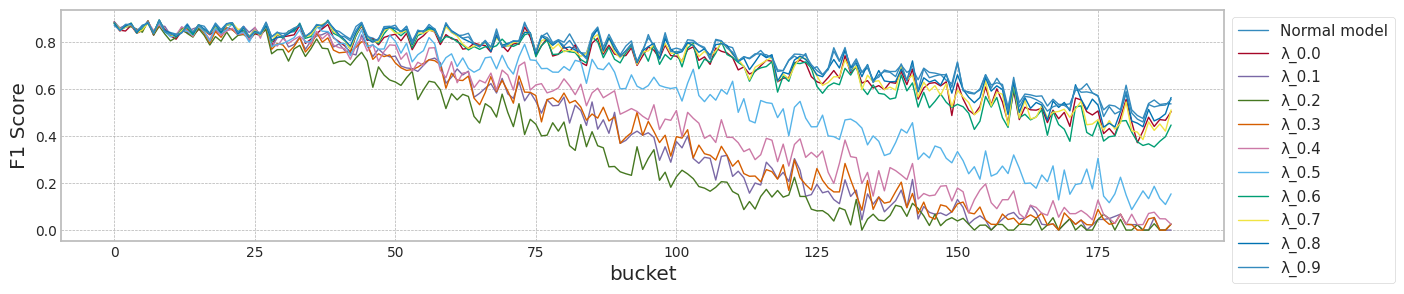

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #5, Normal model  0.906077  0.879630  0.744809  0.536082  0.433155
1                     0.0  0.906077  0.884793  0.707177  0.502924  0.415900
2                     0.1  0.916201  0.884793  0.420739  0.000000  0.416446
3                     0.2  0.898876  0.879630  0.360673  0.025316  0.404178
4                     0.3  0.911111  0.879630  0.427754  0.025000  0.406087
5                     0.4  0.911111  0.879630  0.478488  0.024691  0.437913
6                     0.5  0.911111  0.874419  0.568542  0.153846  0.437913
7                     0.6  0.911111  0.879630  0.695236  0.446154  0.437913
8                     0.7  0.911111  0.879630  0.714117  0.510067  0.437913
9                     0.8  0.911111  0.879630  0.730007  0.562874  0.437913
10                    0.9  0.907104  0.869159  0.741297  0.554348  0.453450
max_mean_lambda= 0.9


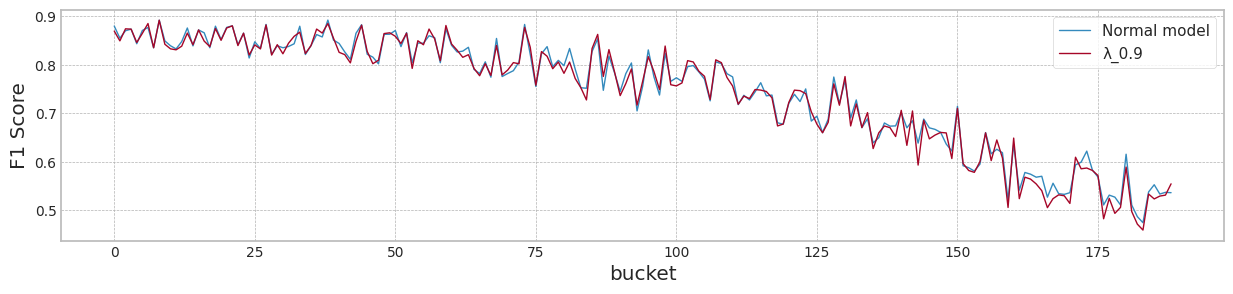

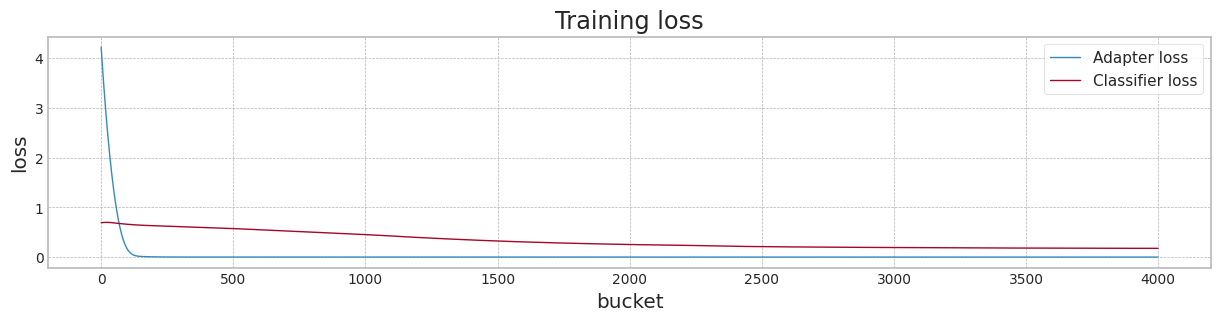

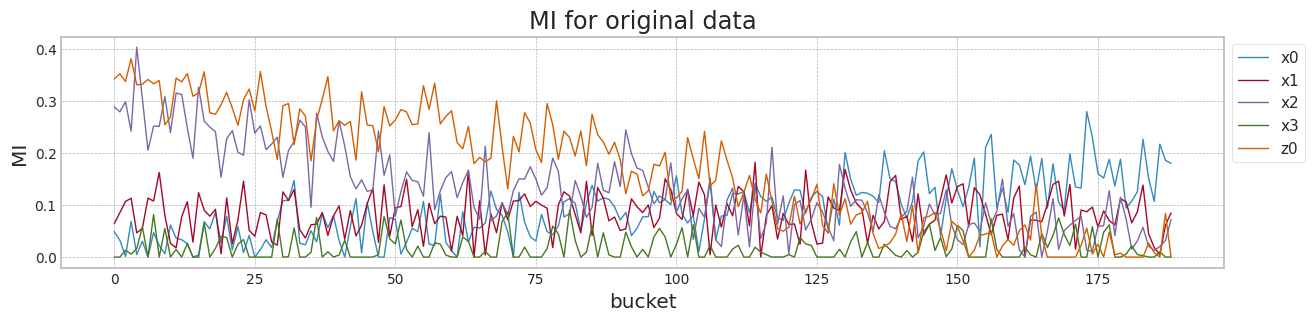

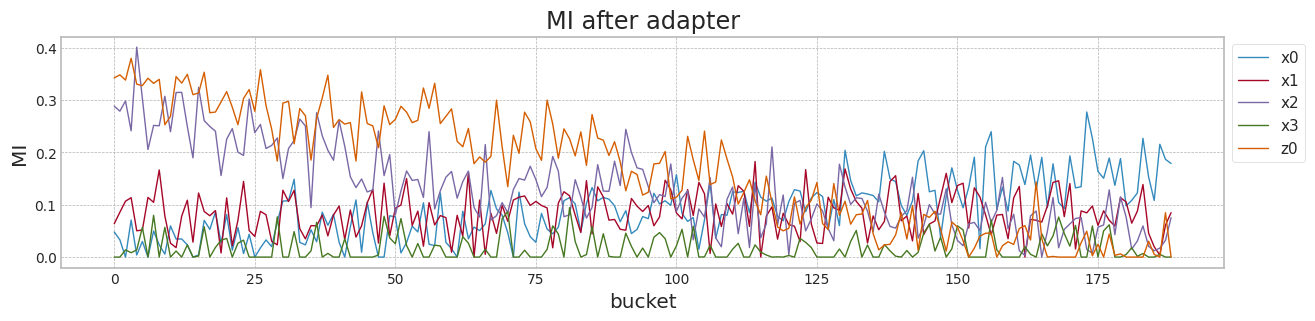

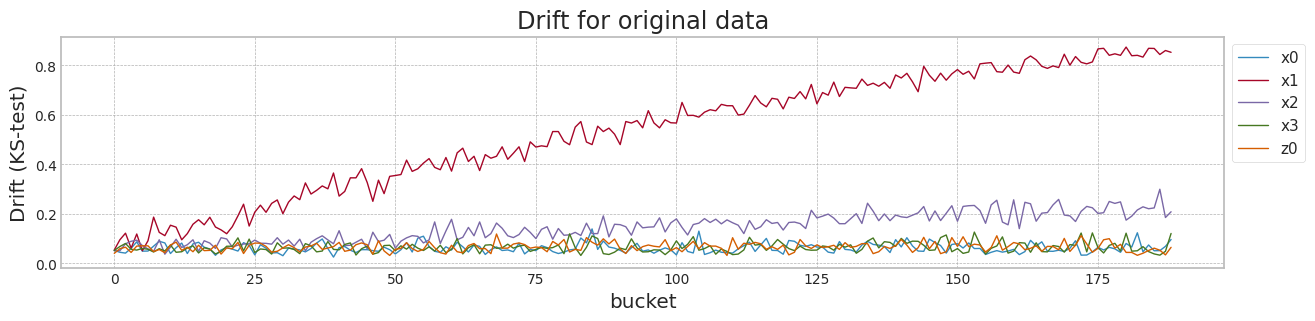

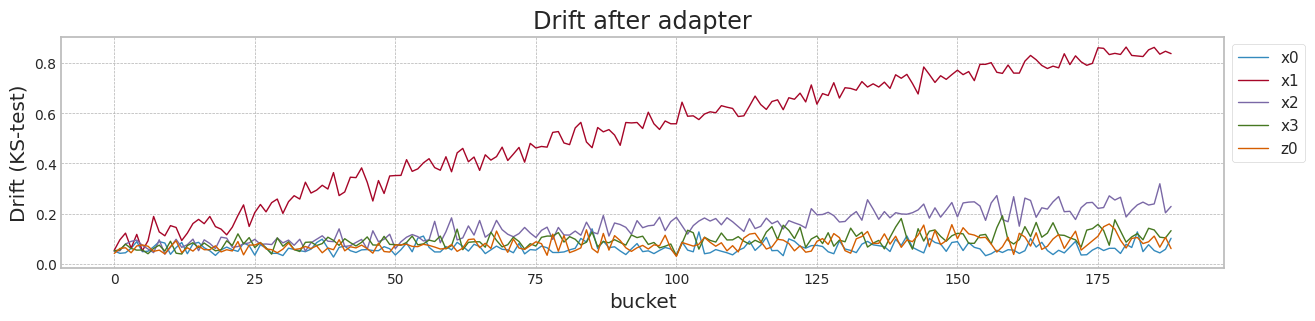

In [313]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X4[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y4[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X4[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X4[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y4[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X4[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [-0.1, 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091]
lambda_f_set2 = [1.0]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf  = test_all_data(last_generator,last_adapter,
                                           X4[0:1800][['x0','x1','x2','x3','z0']],
                                           X4[2000:][['x0','x1','x2','x3','z0','b']],
                                           y4[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #5, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()


# real-world data(Loan data)의 실험

In [ ]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

## Data load

In [ ]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

## Data 정제

In [ ]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

In [ ]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

## Dataset 만들기

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:

X[2010].shape

In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

## Data의 MI, Drift 특성 파악
+ MI Top 5에 대하여 MI의 변화
+ MI Top 5에 대하여 Drift의 변화

In [ ]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

In [ ]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

In [ ]:
list(COLUMNS) not in top_columns_index

In [ ]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2_df = pd.DataFrame(X2,columns = COLUMNS)
X2_df_t5 = X2_df[top_columns]

In [ ]:
from tqdm import tqdm

bucket_size_array=[5000]#[10,50,100,200]
tl = X[2010].shape[0]

for bucket_size in bucket_size_array:

    MIS = {}
    DRF = {}
    for col in top_columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((X2.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2_df_t5[bk*bucket_size:bk*bucket_size+bucket_size],
                                   Y2[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X_df[top_columns].values,X2_df_t5[bk*bucket_size+tl:bk*bucket_size+bucket_size+tl].values)
        for ix,col in enumerate(top_columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Loan data의 학습

In [ ]:
import copy
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tl,fl = X[2010].shape

loan_scaler = MinMaxScaler()
LX = loan_scaler.fit_transform(X[2010][:,top_columns_index])

X_train = torch.tensor(LX[0:int(tl*0.9)], dtype=torch.float32).to(device)
y_train = torch.tensor(Y[2010][0:int(tl*0.9)], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(LX[int(tl*0.9):tl], dtype=torch.float32).to(device)
y_test = torch.tensor(Y[2010][int(tl*0.9):tl], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
loan_model = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)


# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(loan_model.parameters(), lr=0.0001)

n_epochs = 100   # number of epochs to run
batch_size = 1000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = -np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    loan_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = loan_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    loan_model.eval()
    y_pred = loan_model(X_test)
    y_pred = (y_pred.cpu().data.numpy()> 0.5).astype(float)
    f1 = f1_score(y_pred, y_test.cpu().data.numpy())
    f1 = float(f1)
    history.append(f1)
    if f1 > best_mse:
        best_mse = f1
        best_weights = copy.deepcopy(loan_model.state_dict())

# restore model and return best accuracy
loan_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
bucket_size_array=[3000]

for bucket_size in bucket_size_array:
    bucket_count = int(X2.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(loan_scaler.transform(X2[bk*bucket_size:bk*bucket_size+bucket_size][:,top_columns_index]), dtype=torch.float32).to(device)
        predicted_y = loan_model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y2[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Loan data, Feature 81')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(0.0)

pd.DataFrame(result_table3)

## Concept-drift tolerant model 적용.

+ 100개씩 한 bucket으로 만든다.

In [ ]:
df_accepted['b'] = (np.asarray(list(df_accepted.index))/100).astype(int)

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:
# bucket b의 확인!
X[2010][:,81]

In [ ]:
sum(X[2010][:,81]==57)

In [ ]:
X[2010][0,81] = 58
X[2010][1,81] = 58
X[2010][2,81] = 58

In [ ]:
sum(X[2010][:,81]==57)

In [ ]:
sum(X[2010][:,81]==58)

In [ ]:
sum(X[2010][:,81]==172)

In [ ]:
X[2010].shape

In [ ]:
X[2010][103:].shape

In [ ]:
X_df_t5 = pd.DataFrame(X[2010],columns=list(COLUMNS) + ['b'])[top_columns]

+ 학습셋 X[2010]에서, MI와 Drift의 변화

In [ ]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]
#bucket 58의 개수
tl = sum(X[2010][:,81]==58)

for bucket_size in bucket_size_array:

    MIS = {}
    DRF = {}
    for col in top_columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int(X[2010][tl:].shape[0]/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X_df_t5[bk*bucket_size:bk*bucket_size+bucket_size],
                                   Y[2010][bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X_df_t5[0:103].values,X_df_t5[bk*bucket_size+tl:bk*bucket_size+bucket_size+tl].values)
        for ix,col in enumerate(top_columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

+ 상태를 보니.... 좋은 결과가 안나올 듯... 싶은데...

### Concept-drift tolerant model 적용

<pre>
x0 --------------------------------------> |                        |
x1 --------------------------------------> |                        |
x2 --------------------------------------> |                        |
x3 --------------------------------------> |                        |
x4 --------------------------------------> | Discriminator (D(x,g)) |
                    ...                    | predictive model       | -> y^
xi+1----->|                     |- x'i+1-> |                        |
xi+2----->|  Generator G(xi,b)  |- x'i+2-> |                        |
xi+3----->|  (Adaptive model)   |- x'i+3-> |                        |
xi+4----->|                     |- x'i+4-> |                        |
xi+5----->|                     |- z'i+5-> |                        |
                     ^
                     |
                     b
</pre>

+ 위와 같이, MI Top5의 feature에 대하여 G를 적용하고, 나머지 feature는 그대로 Classification model에 들어가게 한다.

In [ ]:
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
#X2 = np.concatenate((X[2011],X[2012],X[2013]))
#Y2 = np.concatenate((Y[2011],Y[2012],Y[2013]))
max_b = np.max(X2[:,81])
max_b

In [ ]:

def train_model5(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]

    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    fl = 81
    generator = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net().to(device)
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        # MI 높은 top 5의 column에 대해서 b에 대한 전처리 처리를 한다.
        if lambda_f > 0.0:
            xs = adapter(XS_train[:,top_columns_index],XS_train[:,81].reshape(-1,1)/max_b) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,top_columns_index]))
        else:
            xs = XS_train[:,top_columns_index]
            a_loss = 0

        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f > 0.0:
            loss = (1-lambda_f) * g_loss + lambda_f * a_loss * alpha
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_A.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )


    generator.eval()

    if lambda_f > 0.0:
        adapter.eval()
        ax = adapter(XS_test[:,top_columns_index],XS_test[:,81].reshape(-1,1)/max_b)
        #XS_test[:,top_columns_index] = ax
    else:
        ax = XS_test[:,top_columns_index]
        adapter = None

    y_hat = generator(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',y_test.shape)
    print('y_hat',y_hat.shape)

    f1 = f1_score(y_test.cpu().data.numpy(),y_hat)

    mi = 0.0
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))

    return f1,mi,generator,adapter

In [ ]:

def test_all_loan_data(generator,adapter,XT,yT):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('XT.shape',XT.shape)
    bucket_size_array=[3000]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size], dtype=torch.float32).to(device)
            if adapter == None:
                xs = tmp_x[:,top_columns_index]
            else:
                xs = adapter(tmp_x[:,top_columns_index],tmp_x[:,81].reshape(-1,1)/max_b)
            #tmp_x[:,top_columns_index] = xs
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))
    return f1s

In [ ]:
# 2010의 마지막 bucket의 개수가 94개... 157

loan_scaler = MinMaxScaler()
LX = loan_scaler.fit_transform(X[2010][:,0:81])
LX = np.concatenate((LX,X[2010][:,81].reshape(-1,1)),axis=1)

train_tensors = Namespace(XS_train = torch.tensor(LX[0:LX.shape[0] - 94], dtype=torch.float32),
                          y_train = torch.tensor(Y[2010][0:LX.shape[0] - 94], dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(LX[LX.shape[0] - 94:LX.shape[0]], dtype=torch.float32),
                         y_test = torch.tensor(Y[2010][LX.shape[0] - 94:LX.shape[0]], dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=200, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

# -0.1 은 기준 모델의 학습을 위한것.
lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.0] #[0.391]

for lambda_f2 in lambda_f_set2:

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model5(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        TX = np.concatenate((loan_scaler.transform(X2[:,0:81]),X2[:,81].reshape(-1,1)),axis=1)
        result_table[f'lambda_{lambda_f}'] = test_all_loan_data(last_generator,last_adapter, TX , Y2)

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])